# The Billboard Hot 100

Started by Billboard Magazine the Billboard Hot 100 is the industry standard record chart in the United States. It is published on a weekly basis (the cut-off date being Saturday). 

Chart rankings are based on sales (physical and digital), radio play, and online streaming in the United States. If we define success of a song as commercial success, the charts are hence a way to understand the profitability of a song (in the largest sense).

The weekly tracking period for sales was initially Monday to Sunday when Nielsen started tracking sales in 1991, but was changed to Friday to Thursday in July 2015. This tracking period also applies to compiling online streaming data. Radio airplay, which, unlike sales figures and streaming, is readily available on a real-time basis, is tracked on a Monday to Sunday cycle (previously Wednesday to Tuesday). A new chart is compiled and officially released to the public by Billboard on Tuesdays.

The Billboard Hot 100 is by far not the most accurate tool for identifying all commercially successful songs as their rules and tracking tools are subject to flaws. A common example of this is their policy to not include songs that weren't released as singles (revoked in 1998). This led to some of the most commercially successful songs never making it onto the Hot 100. Nevertheless, it's the best tool we have readily available.

The Billboard Hot 100 goes way back to 1958 and has had hundreds of songs listed and yet, I'm fascinated that only a small amount of all music makes its way onto this chart. In this notebook I'll explore the songs that make it onto the Hot 100 and in the process answer a few questions, I've always had about this famous weekly list.

In [1]:
import numpy as np
import pandas as pd

hot100 = pd.read_csv('../data/processed/hot100.csv',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date'],sep='\t')
hot100_uniq = hot100.drop_duplicates(subset=['artist','title']).drop('rank',axis=1)
hot100_uniq.set_index(['artist','title'],drop=True,inplace=True)
train = pd.read_csv('../data/processed/train.csv',sep='\t').set_index(['artist','title'])
test = pd.read_csv('../data/processed/test.csv',sep='\t').set_index(['artist','title'])
combined = pd.concat([train, test]).sort_index()

hits = train.loc[train.hit == True,:].copy()
nhits = train.loc[train.hit == False,:].copy()

hot100.head(5)

,rank,date,year,month,day,title,artist,week,reentry,streak,...,peak_day,leap_week,leap,max_leap,max_leap_date,max_leap_week,max_leap_year,max_leap_month,max_leap_day,low
0,1,1967-07-08,1967,7,8,Windy,The Association,7,0,13,...,27,7,0.0,24.0,1967-06-03,2.0,1967.0,6.0,3.0,52
1,2,1967-07-08,1967,7,8,Little Bit O' Soul,The Music Explosion,9,0,15,...,13,9,1.0,33.0,1967-05-27,3.0,1967.0,5.0,27.0,90
2,3,1967-07-08,1967,7,8,Can't Take My Eyes Off You,Frankie Valli,8,0,15,...,20,8,4.0,21.0,1967-05-27,2.0,1967.0,5.0,27.0,74
3,4,1967-07-08,1967,7,8,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,7,0,11,...,27,7,0.0,43.0,1967-06-03,2.0,1967.0,6.0,3.0,98
4,5,1967-07-08,1967,7,8,Don't Sleep In The Subway,Petula Clark,6,0,9,...,3,6,5.0,27.0,1967-06-10,2.0,1967.0,6.0,10.0,76


In [2]:
# Define Main Columns
main_cols_hot100 = ['rank','date','week','title','artist','reentry','streak','ranked','entry','exit','peak','low','max_leap','leap']
main_cols_hot100_uniq = ['entry_year','exit_year','reentry','streak','ranked','entry','exit','peak','low','max_leap']
main_cols_analysis = ['id','hit','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','popularity','speechiness','tempo','time_signature','valence']

In [3]:
hot100.loc[:,main_cols_hot100].describe().T

,count,mean,std,min,25%,50%,75%,max
rank,316685.0,50.501094,28.866120,1.0,26.0,51.0,76.0,100.0
week,316685.0,9.045604,7.423191,1.0,4.0,7.0,13.0,87.0
reentry,316685.0,0.125276,0.486193,0.0,0.0,0.0,0.0,14.0
streak,316685.0,15.683979,9.305860,0.0,9.0,15.0,19.0,84.0
ranked,316685.0,17.091207,9.619444,1.0,10.0,16.0,20.0,87.0
entry,316685.0,78.154832,19.982164,1.0,71.0,84.0,92.0,100.0
exit,316685.0,72.582074,23.201009,1.0,49.0,79.0,95.0,100.0
peak,316685.0,30.615116,26.069466,1.0,7.0,24.0,50.0,100.0
low,316685.0,88.102910,13.118246,3.0,83.0,93.0,98.0,100.0
max_leap,314707.0,17.311973,10.813475,-83.0,11.0,15.0,22.0,96.0


# Data

The **Hot 100 charts, hits sample, audio-features and non-hits sample** have been obtained from **Billboard.com (Hot 100)** and the **Spotify API (Audio Features and Non Hits Sample)**

The **hits** sample is a subset of the **Hot 100** charts, enriched using the [Spotify Audio Features Endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/). Unfortunately, not all songs could be matched with a Spotify ID and retrieved. Hence, **hits** has dropped all songs that came back empty.

The **non-hits** sample is sampled using the [Spotify API Search](https://developer.spotify.com/documentation/web-api/reference/search/search/), randomly sampling a songs by year, so as to find songs that did not become hits. As that method overemphasizes popular songs, I've sampled 20% of each year from the lowest popularity (i.e. Spotify's popularity score).

For more information check out the Wrangling notebook *Wrangling (Hot 100 and Spotify Sample)*.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

GrayP = ['#ff7cb9',"gray","black"]
sns.set_palette(GrayP)

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.options.display.max_columns = 400
pd.options.display.max_rows = 1000

# The Distributions

We'll start by looking into the general distribution of songs in the Hot 100 to better understand the structure within hits. This is a way to identify exceptional songs and those that stick out. Often the most predictive information lies in the extremes, which is why we want to know what those songs are.

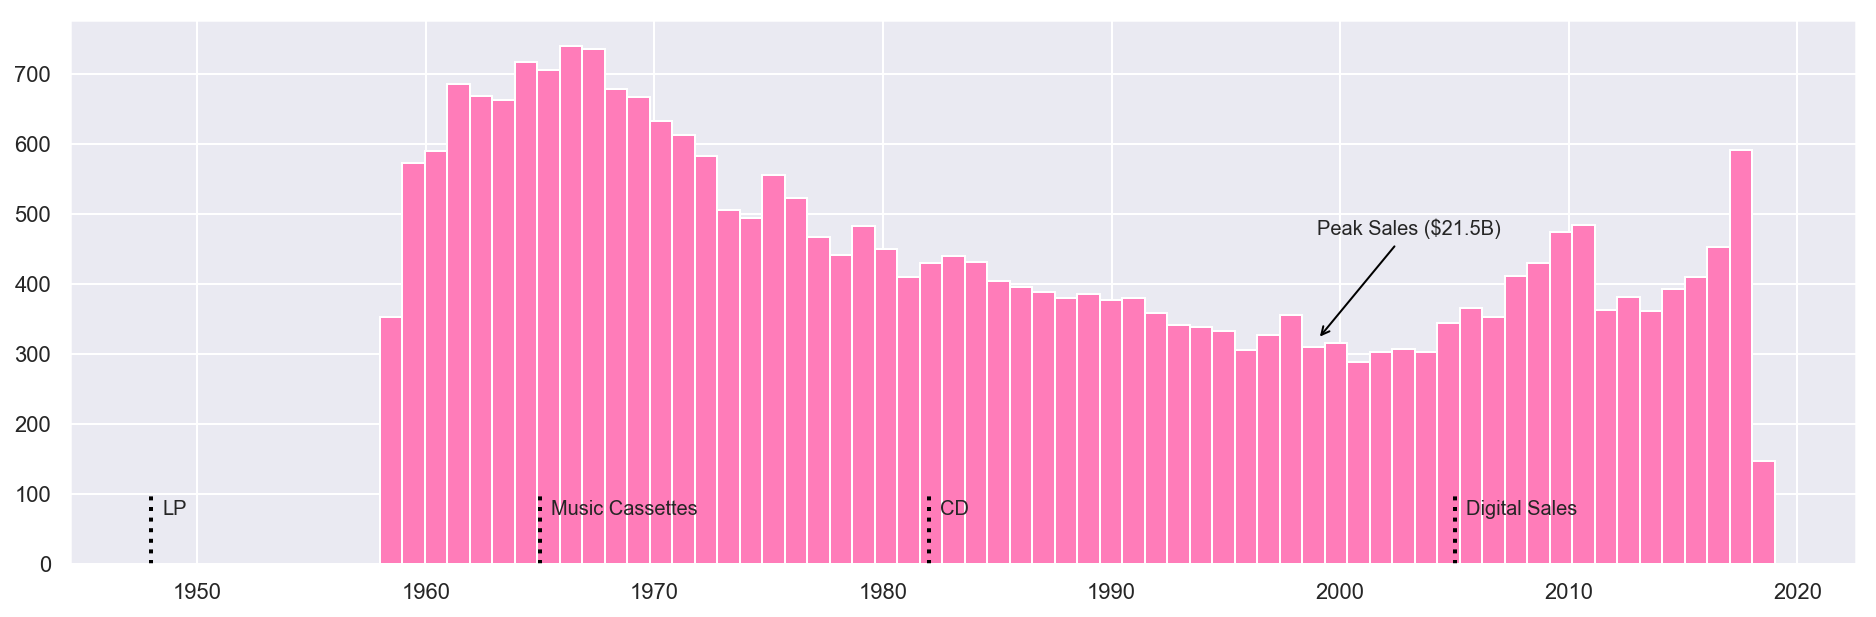

In [5]:
_ = plt.figure(figsize=(16,5))

def annotate_timeline(x,text):
    _ = plt.plot([x,x],[0,100],linestyle='dotted',linewidth=2,color='black')
    _ = plt.annotate(s=text,xy=(x,20),xytext=(x + .5,70))

years = len(hot100_uniq['entry_year'].unique())
_ = plt.hist(hot100_uniq['entry_year'],bins=years,color=GrayP[0])
_ = annotate_timeline(1948,'LP')
_ = annotate_timeline(1965,'Music Cassettes')
_ = annotate_timeline(1982,'CD')
_ = plt.annotate(s='Peak Sales ($21.5B)',xy=(1999,320),xytext=(1999,470),arrowprops=dict(arrowstyle="->",color='black'))
_ = annotate_timeline(2005,'Digital Sales')

In [6]:
# Number of Unique Songs on the Hot 100 since 1958
print("Since 1958 there were *{}* songs on the Billboard Hot 100.".format(len(hot100_uniq)))

Since 1958 there were *28083* songs on the Billboard Hot 100.


It looks like over the years songs stayed on the Billboard Hot 100 for a longer time (streak length increased) and we had less fluctuation (i.e. new songs entering and old songs dropping off). However, in more recent years this fluctuation seems to be picking back up again.

One of the lowest fluctuation points also coincides with the high point of sales in the music industry.

Let's have a closer look at streaks!

# Streaks

There are several indicators of popularity and one of those is the length of a song staying on the Hot 100 as it shows consistent interest (i.e. radio play, sales etc.). 

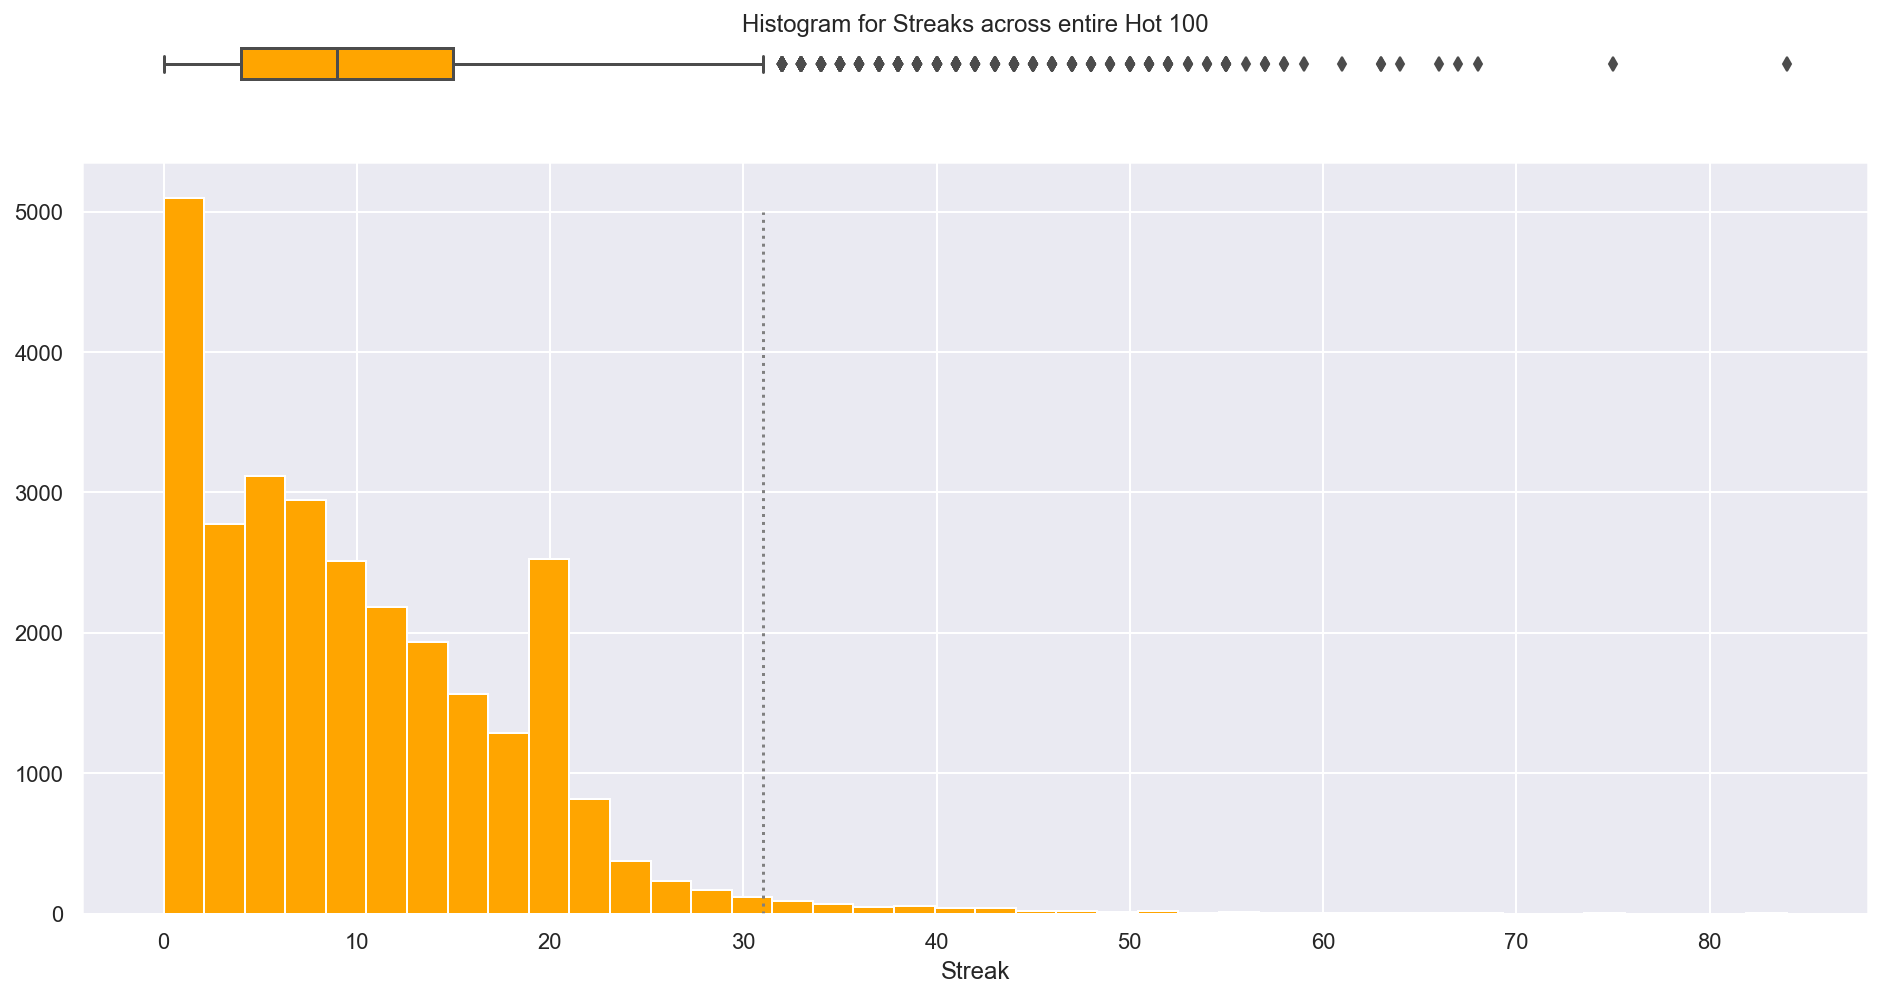

Outliers in Streaks across the entire data set (according to 1.5 IQR rule): >31


In [7]:
GrayO = ['orange',"gray","black"]
sns.set_palette(GrayO)

def get_outlier_boundary(series):
    first_q = series.quantile(q=0.25)
    third_q = series.quantile(q=0.75)
    iqr = (third_q - first_q)
    return int(third_q + iqr * 1.5)

def create_hist(x,std=False,xticks=False,bins=50,figsize=(16,8)):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.05, .95)}, figsize=figsize)

    _ = sns.boxplot(x, ax=ax_box,saturation=1)
    _ = ax_box.grid(False)
    _ = ax_box.set_facecolor('white')
    _ = ax_box.set(yticks=[])
    _ = ax_box.set_xlabel(None)

    _ = ax_hist.hist(x,bins=bins)
    if xticks:
        _ = ax_hist.set_xticks(np.arange(xticks[0],xticks[1]+xticks[2],xticks[2]))
    if std:
        plus_two_std = x.mean() + x.std()*1.96
        minus_two_std = x.mean() - x.std()*1.96
        _ = ax_hist.plot([plus_two_std,plus_two_std],[0,500],c='black')
        _ = ax_hist.annotate(s='μ + 2σ',xy=[plus_two_std,500],xytext=[plus_two_std - 3,550])
        _ = ax_hist.plot([minus_two_std,minus_two_std],[0,500],c='black')
        _ = ax_hist.annotate(s='μ - 2σ',xy=[minus_two_std,500],xytext=[minus_two_std - 3,550])
    return ax_box,ax_hist

ax_box, ax_hist = create_hist(hot100_uniq['streak'],xticks=(0,80,10),bins=40)
_ = ax_box.set_title('Histogram for Streaks across entire Hot 100')
_ = ax_hist.set_xlabel('Streak')

ax_hist.plot([31,31],[0,5000],linestyle='dotted')

plt.show()

upper_whisker = get_outlier_boundary(hot100_uniq['streak'])
print('Outliers in Streaks across the entire data set (according to 1.5 IQR rule): >{}'.format(upper_whisker))

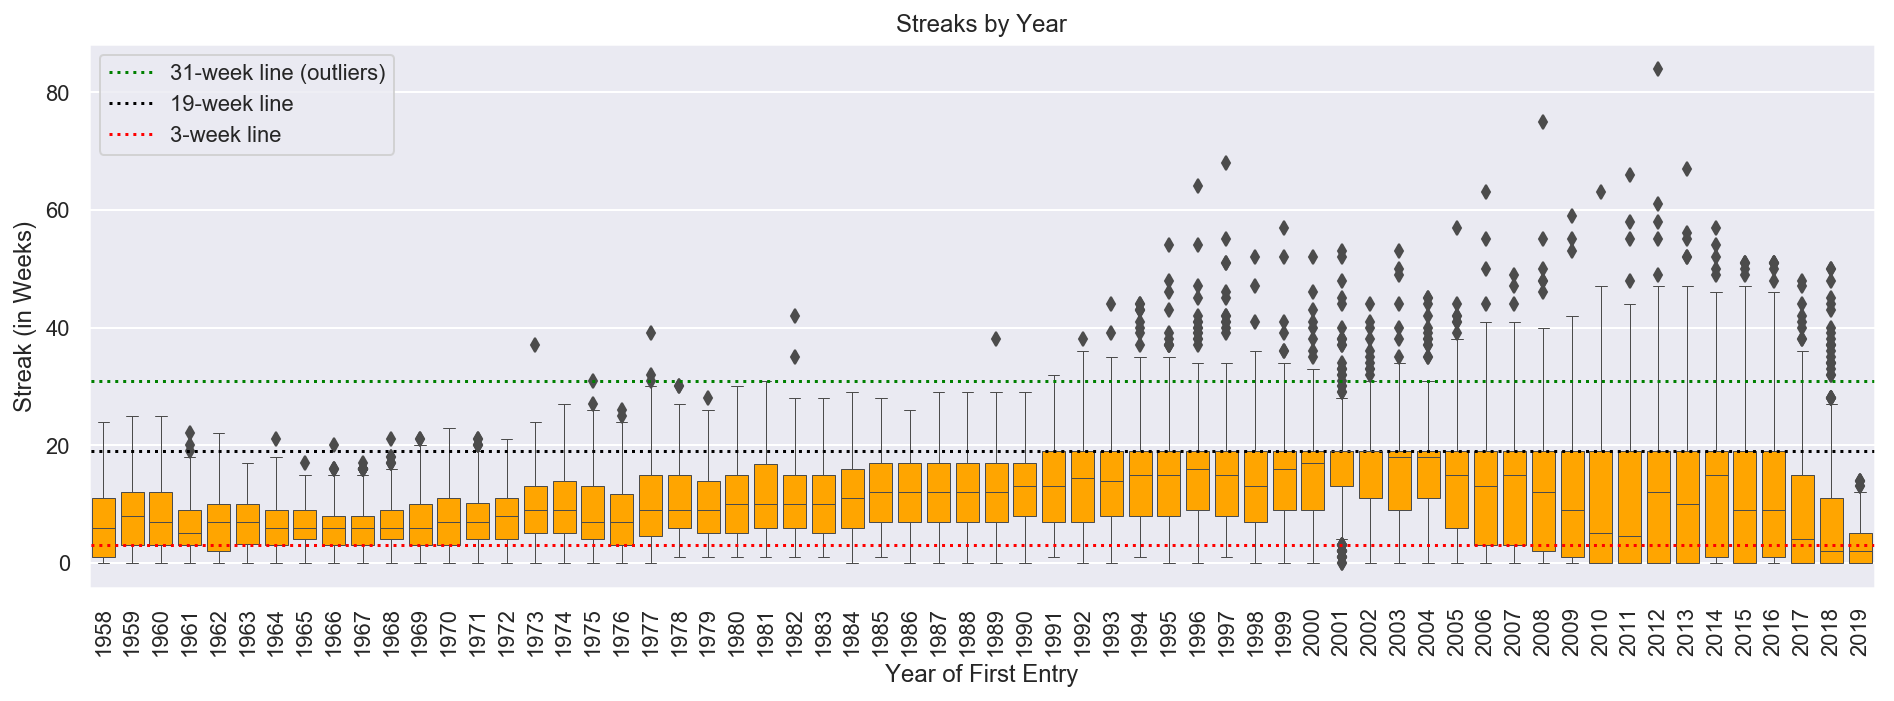

In [8]:
_ = plt.figure(figsize=(16,5))

_ = sns.boxplot(x='entry_year',y='streak',data=hot100_uniq,color=GrayO[0],saturation=1,linewidth=0.5)
_ = plt.plot([-1,62],[upper_whisker,upper_whisker],c='green',linestyle='dotted',label='31-week line (outliers)')
_ = plt.plot([-1,62],[19,19],c='black',linestyle='dotted',label='19-week line')
_ = plt.plot([-1,62],[3,3],c='red',linestyle='dotted',label='3-week line')
_ = plt.xticks(rotation=90)
_ = plt.title('Streaks by Year')
_ = plt.xlabel('Year of First Entry')
_ = plt.ylabel('Streak (in Weeks)')
_ = plt.legend()

plt.show()

### 19-week Pattern of lower 75% (third quartile)

Between 1991 and 2016 the third quartile (i.e. upper quartile) is consistently at 19 streak weeks (i.e. 20th ranked week due to the 0-indexing). There's no deviation from this pattern, no single year has a third quartile that surpasses this threshold. Looking into the underlying formula it looks like it has to do with an artificial Hot 100 rule introduced in 1991 to speed up fluctuation ([20-20 rule](https://web.stanford.edu/~xhnguyen/BillboardandTechnology.pdf)). This rule specifies that a song that has fallen out of the top 20 will be removed after 20 weeks. The rule was relaxed in 1992 and 1993 to falling out of the top 40 and top 50 respectively.

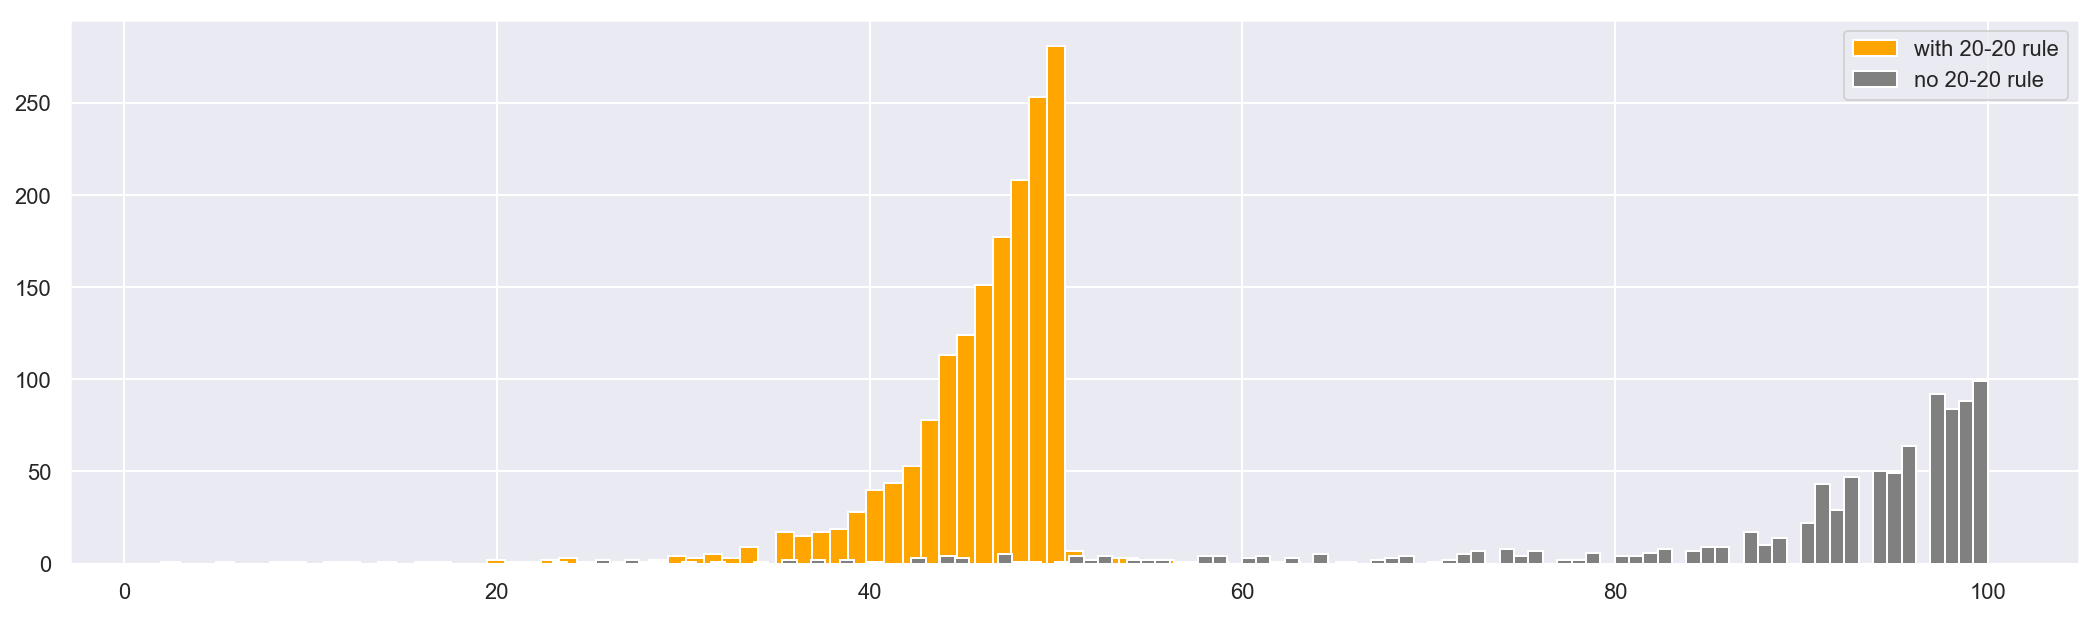

Number of songs whose streak was likely cut short: 1693


In [9]:
fig = plt.figure(figsize=(18,5))
_ = plt.hist(hot100_uniq.loc[(hot100_uniq['streak']>19) & (hot100_uniq['exit_year']>1991),'exit'], bins=100, label='with 20-20 rule')
_ = plt.hist(hot100_uniq.loc[(hot100_uniq['streak']>19) & (hot100_uniq['exit_year']<=1991),'exit'], bins=100, label='no 20-20 rule')
_ = plt.legend()
plt.show()

print("Number of songs whose streak was likely cut short: {}".format(len(hot100_uniq.loc[(hot100_uniq['streak']>19) & (hot100_uniq['exit_year']>1991),'exit'])))

Above we can see the exit positions of songs with >19 weeks streak before and after the 20-20 rule. It can be assumed that this rule has cut the streak of songs after 1991 short as we can see that generally songs would exit at the bottom of the Hot 100 (see `no 20-20 rule`) rather dropping suddenly.

### Super Songs

Until the early 1970s no song title would be on the Hot 100 for more than 25 weeks and until the early 1990s staying charted for over 31 weeks (i.e. outliers across the entire data as shown above) was the rare exception. In fact, there are only 6 artists who've achieved this feat (they are listed below).

There is a clear pattern distinction between the charts after 1991 and previous periods. 1991 happens to be the year that the Hot 100 started to use Nielsen Soundscan, which gathered more precise music sales data (previously sales numbers were self-reported by stores). [Hot 100 Formula changes](https://en.wikipedia.org/wiki/Billboard_Hot_100) and [discussion](https://ndsmcobserver.com/2018/01/billboard-hot-100-controversy/)

In [10]:
outlier_bf_1991 = hot100_uniq.loc[(hot100_uniq['year'] < 1991) & (hot100_uniq['streak'] > upper_whisker),['streak','peak','entry','exit']]
outlier_af_1991 = hot100_uniq.loc[(hot100_uniq['year'] >= 1991) & (hot100_uniq['streak'] > upper_whisker),['streak','peak','entry','exit']]

print("Number of Titles that stayed on the Hot 100 for more than 30 weeks \nBefore 1991 (33 years) - {}\nAfter 1991 (29 years) - {}".format(len(outlier_bf_1991),len(outlier_af_1991)))

Number of Titles that stayed on the Hot 100 for more than 30 weeks 
Before 1991 (33 years) - 6
After 1991 (29 years) - 430


In [11]:
outlier_bf_1991.sort_values(by='streak',ascending=False).head(10)

,,streak,peak,entry,exit
artist,title,,,,
Soft Cell,Tainted Love,42,8,90,97
Paul Davis,I Go Crazy,39,7,89,99
Young M.C.,Bust A Move,38,7,81,90
Kris Kristofferson,Why Me,37,16,100,52
Laura Branigan,Gloria,35,2,84,98
Bee Gees,How Deep Is Your Love,32,1,83,59


Go to Playlist: https://open.spotify.com/user/1162788143/playlist/0iP1Sz5qSCmVomZUNYbKPj?si=8SyDMByGRK60HNPHv9-HZA

In [12]:
outlier_af_1991.sort_values(by='streak',ascending=False).head(10)

,,streak,peak,entry,exit
artist,title,,,,
Imagine Dragons,Radioactive,84,3,93,49
Jason Mraz,I'm Yours,75,6,93,48
LeAnn Rimes,How Do I Live,68,2,89,45
OneRepublic,Counting Stars,67,2,32,50
LMFAO Featuring Lauren Bennett & GoonRock,Party Rock Anthem,66,1,78,49
Jewel,Foolish Games/You Were Meant For Me,64,2,61,47
Adele,Rolling In The Deep,63,1,68,49
Carrie Underwood,Before He Cheats,63,8,92,47
The Lumineers,Ho Hey,61,3,90,50


Go to Playlist: https://open.spotify.com/user/1162788143/playlist/4hzjzSssha8VLHqwbyJiWA?si=xWT5wbXAR7OOeuyCrQKO-w

_NOTE: Unfortunately, there is 52 of the 430 songs missing from the playlist that couldn't be found on Spotify or are missing due to country restrictions._

In [13]:
longest_streak = hot100_uniq.loc[hot100_uniq.streak >= upper_whisker,main_cols_hot100_uniq].sort_values(by='streak',ascending=False)

50% of songs stayed on the Hot 100 for less than 10 weeks. The longest streak is 84 weeks and is held by 'Imagine Dragons' with 'Radioactive', a not so close runner-up is 'Jason Mraz' with 'I'm Yours' (75 weeks). We'll pay close attention to these two but are including any outlier song in the `longest_streak` variable for now. (Again we can see the effect of the 20-20 rule in the second song set's `exit` column - no song exited on a position below 50)



Let's look at outliers for the streak variable by year to have a better look at their distribution.

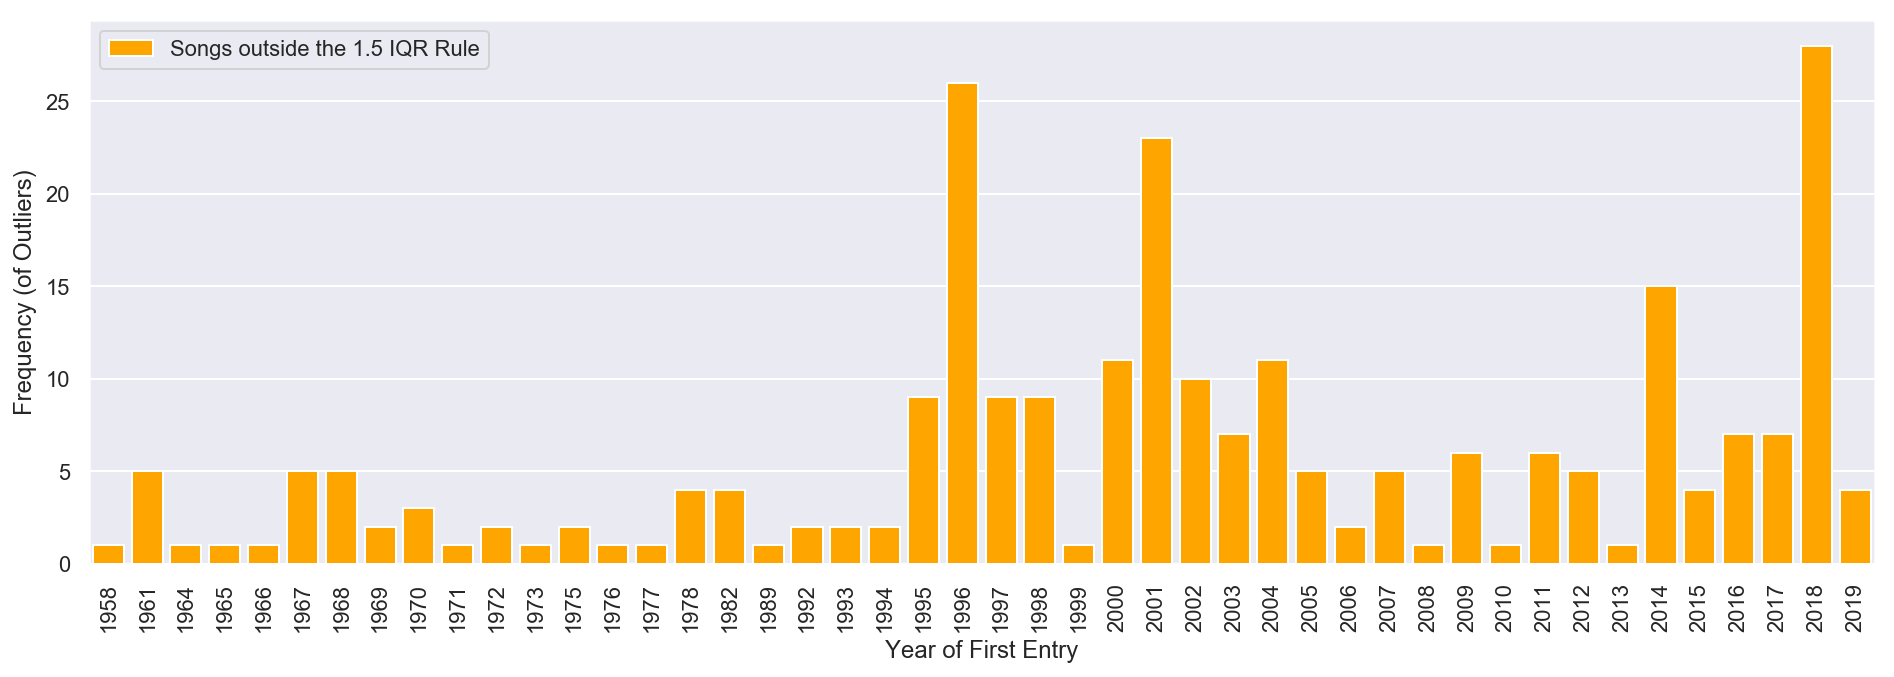

Standard Deviations:
<1991: 5.703656742368894
>=1991: 10.154355499124337


In [14]:
_ = plt.figure(figsize=(16,5))

# Define outlier_boundary by year and retrieve outliers
outlier_boundary = hot100_uniq.groupby(by='year').streak.apply(get_outlier_boundary)
outlier_boundary.name = 'outlier_boundary'
hot100_streak = hot100_uniq.merge(outlier_boundary,on=['year'],how='left')
outliers = hot100_streak.loc[hot100_streak['streak'] > hot100_streak['outlier_boundary'], :]

# Plot data
sns.countplot(outliers.year,color=GrayO[0],saturation=1)
plt.xlabel('Year of First Entry')
plt.xticks(rotation=90)
plt.ylabel('Frequency (of Outliers)')
plt.legend(['Songs outside the 1.5 IQR Rule'])
plt.show()

# Print Standard Deviation along the 1991 boundary
std_bf_1991 = hot100_uniq.loc[hot100_uniq['year'] < 1991,'streak'].std()
std_af_1991 = hot100_uniq.loc[hot100_uniq['year'] >= 1991,'streak'].std()
print("Standard Deviations:\n<1991: {}\n>=1991: {}".format(std_bf_1991,std_af_1991))

Despite the introduction of the 20-20 rule, starting in 1995 we can see a pattern of what I'm going to call 'Super Songs' emerge. Before 1995, there were only few songs that stayed long enough to be considered an outlier (IQR * 1.5 rule). After 1993, however we can suddenly see these breakout songs occuring much more often. Standout years are 1996, 2001 and 2018 but other years are generating outliers more densely as well. This is despite (or due to?) a generally larger standard deviation in streaks on the Hot 100 after 1991. We can also see in the first streak plot that the outliers tend to stray further than outliers before 1991 (i.e. they stay longer on the hot 100 or are 'stickier').

### Higher Fluctuation in Recent Years

Going back to the `Streaks by Year` plot. Starting in 2006 we can see that the first quartile (i.e. lower quartile) is stretching into the <3 weeks region. A pattern we hadn't seen since the mid-1970s. This would indicate a higher fluctuation and is probably a result of Billboard starting slowly incorporating more and more online sales and streaming revenue into their formula since 2005 (https://en.m.wikipedia.org/wiki/Billboard_Hot_100 see _Digital downloads and online streaming_). 

### A First Hypothesis for Weighing

In conclusion, the different streak lengths bring me to a first hypothesis. 

"Not all titles that make it onto the Hot 100 are created equal."

There are different categories (e.g. long-lasting, medium-range, short-stays), with different chances of success on the Hot 100 (success in this case would be defined as staying on the hot 100 a long time. This could allow us to create subcategories with higher probabilities of making it onto the Hot 100 and those that are just flukes/noise. 

# The relationship of Peak Position and Streak Length

In [15]:
GrayG = ['#40c493',"gray","black"]
sns.set_palette(GrayG)

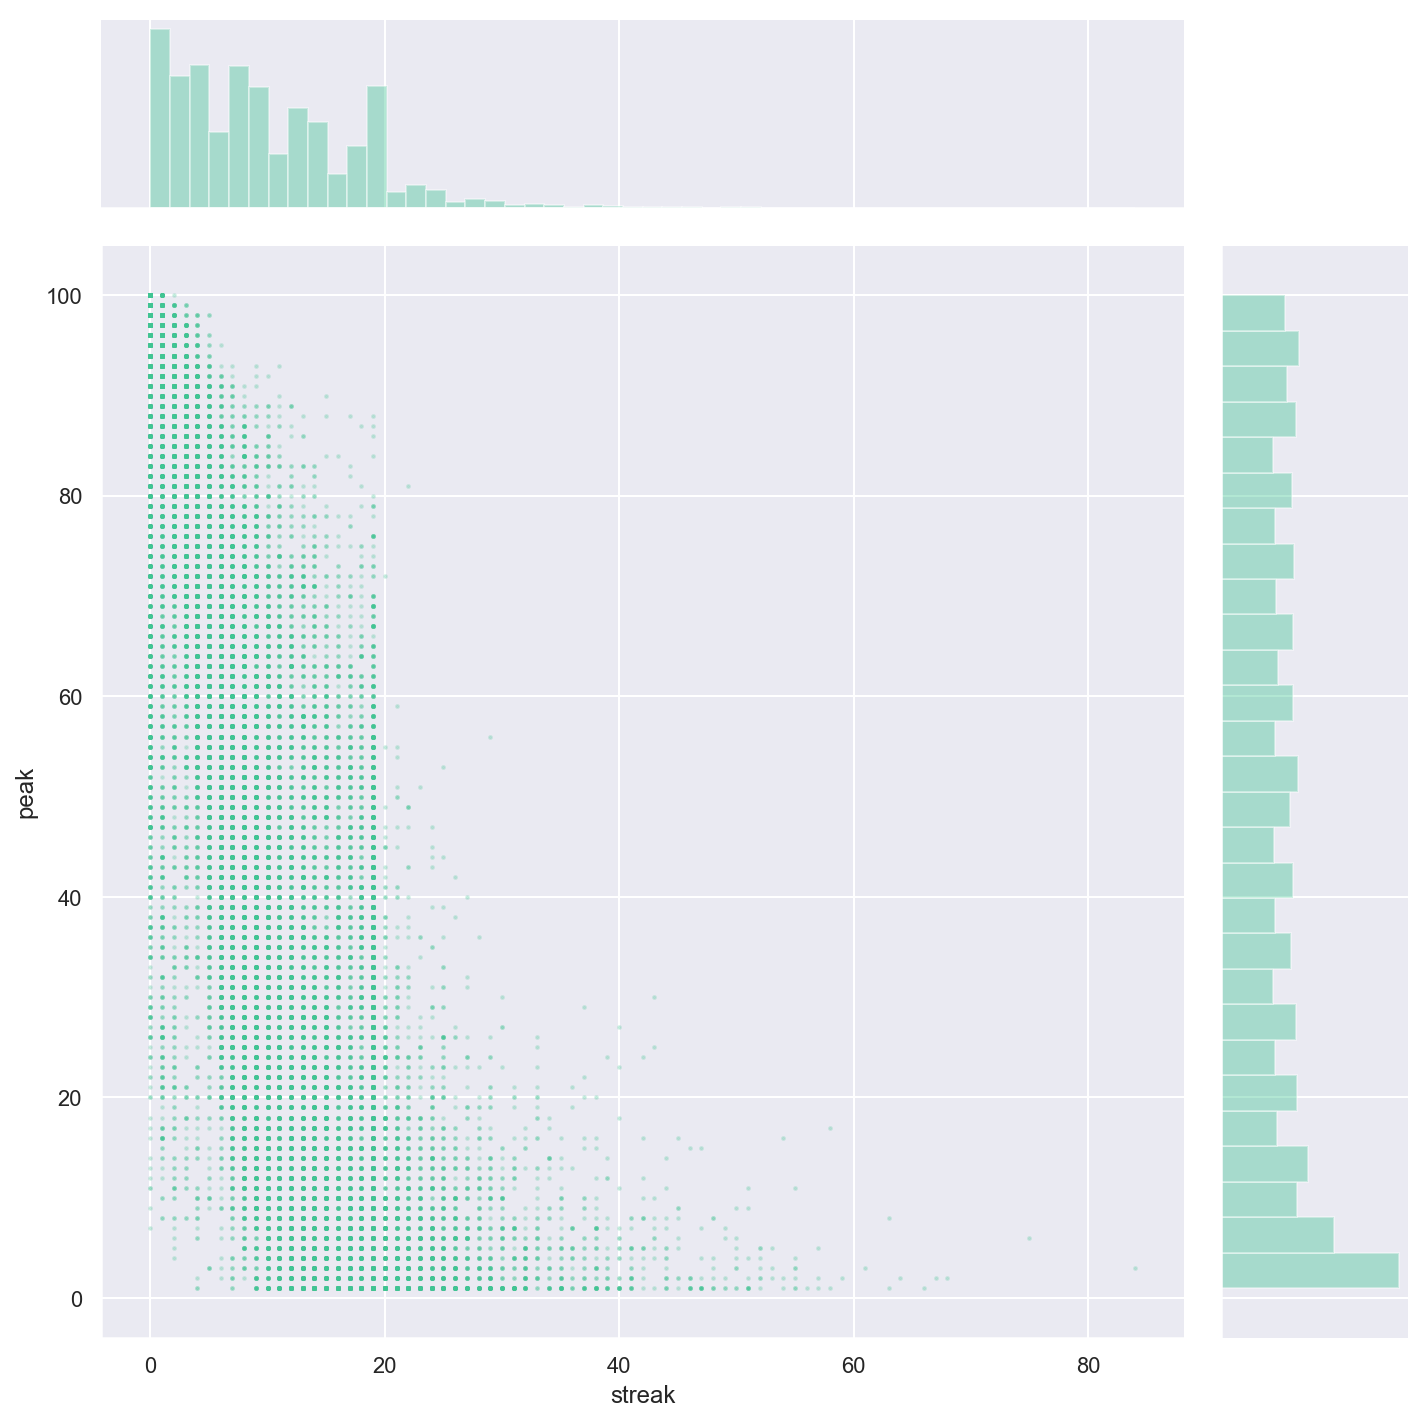

Spearman's R: -0.7857196745443265 p-value: 0.0


In [16]:
from scipy.stats import pearsonr, spearmanr

streak = hot100_uniq['streak']
peak = hot100_uniq['peak']
jp = sns.jointplot(streak,peak,s=2,alpha=0.2,height=10)

plt.show()

print("Spearman's R: {} p-value: {}".format(spearmanr(streak,peak)[0],spearmanr(streak,peak)[1]))

We can see a roughly linear monotonic relationship (tested using Spearman's R). We had to use Spearman's R in this case as Pearson's R requires a normality assumption, which due to the 1-100 scale is rarely given.

Again, at Streak position 19 we can see an unusually bold line, this clearly demarcates the skewedness that the so-called "20-20 rule" (explained above) has introduced in the data. For that reason it's hard to reason that this relationship between streak length and peak position is a factual relationship rather an artificial one.

### Pole Position Streaks

Staying on the Hot 100 is one thing but I'm curious what songs were able to stay on the Hot 100's pole position the longest.

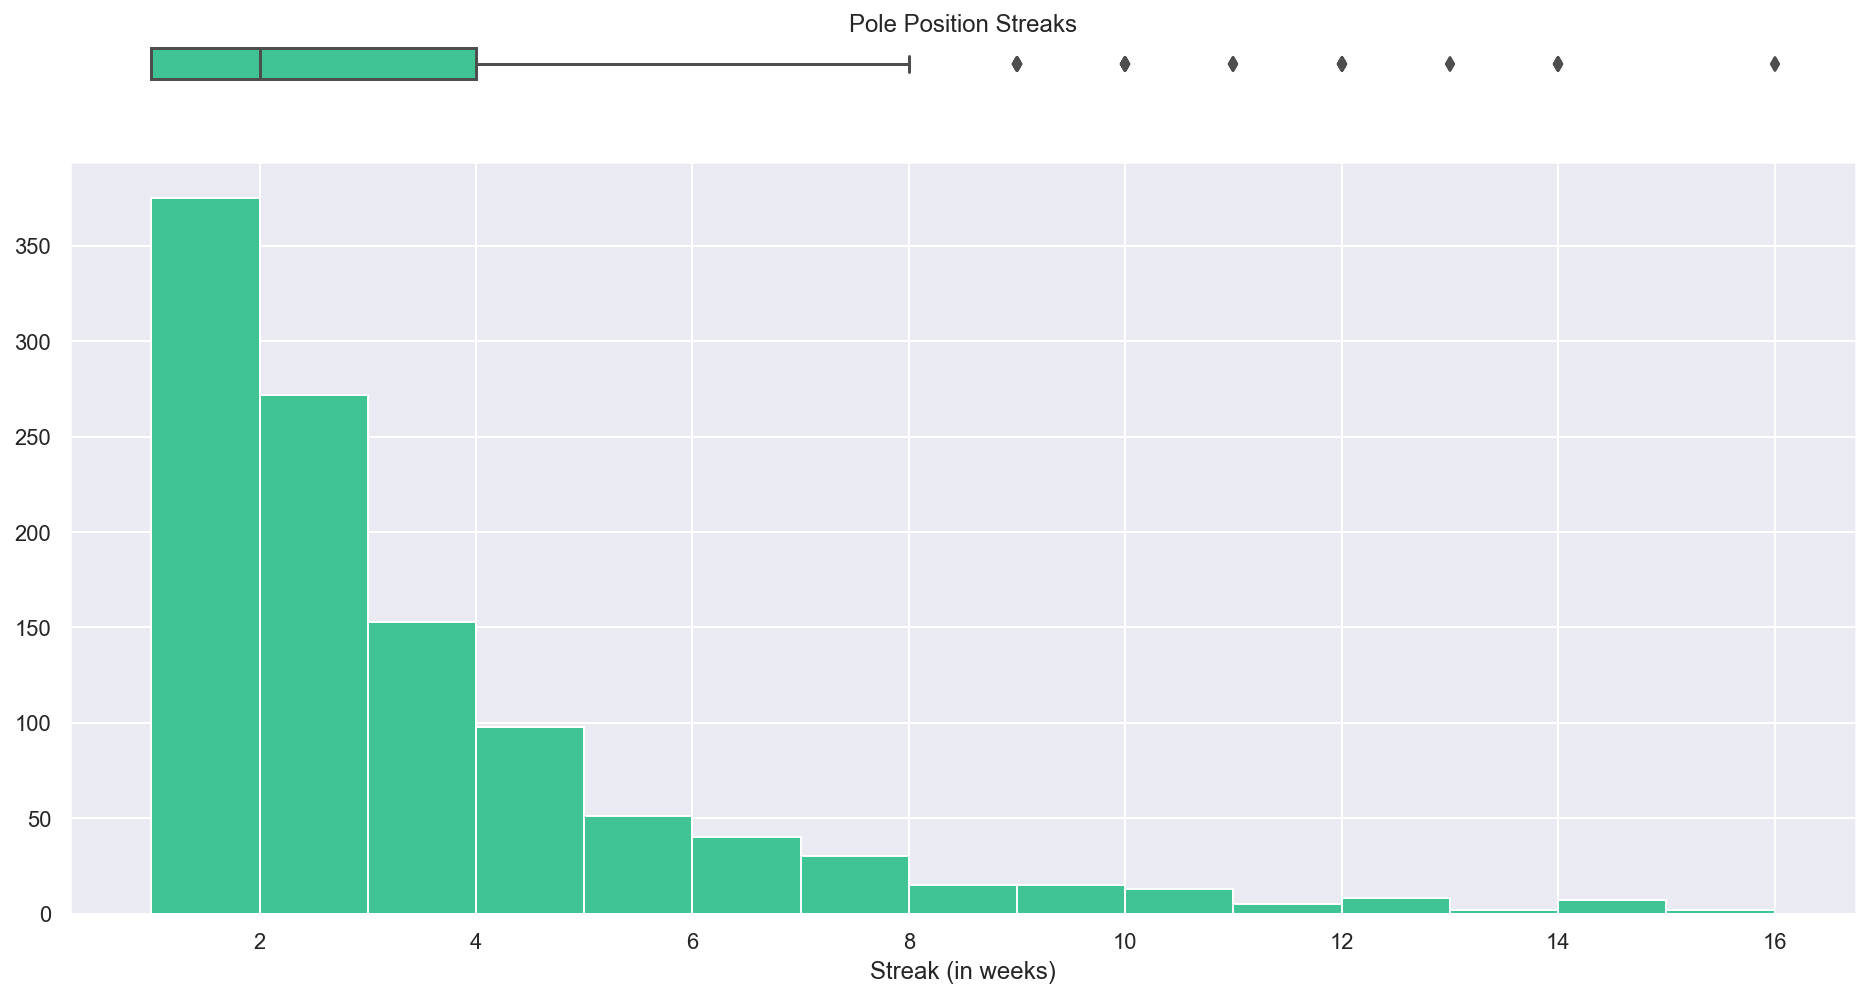

In [17]:
longest_nr_1 = hot100.loc[hot100['rank'] == 1,['artist','title','rank']].rename(columns={'rank':'weeks'}).groupby(by=['artist','title']).count()
ax_box, ax_hist = create_hist(longest_nr_1['weeks'],bins=15)
_ = ax_box.set_title('Pole Position Streaks')
_ = ax_hist.set_xlabel('Streak (in weeks)')

In [18]:
longest_nr_1.sort_values(by='weeks',ascending=False).head(2)

,,weeks
artist,title,
Luis Fonsi & Daddy Yankee Featuring Justin Bieber,Despacito,16
Mariah Carey & Boyz II Men,One Sweet Day,16


In [19]:
print("Total No.1 Hits: {}".format(len(longest_nr_1)))

Total No.1 Hits: 1086


We can see 1086 songs made it to the top of the Hot 100 charts and that less than 50% of those lasted more than 2 weeks on the Hot 100 pole position. Of those only 2 songs were able to stay on the very top of the Hot 100 charts for 16 weeks (i.e. the longest streak).

# Movements

### Who jumped the furthest? Leaps

Now that we've looked at peak positions and streaks, I'm interested to know how the jumps from one position (i.e. a leap) to another are distributed.

In [20]:
GrayB = ['#41b6c4',"gray","black"]
sns.set_palette(GrayB)

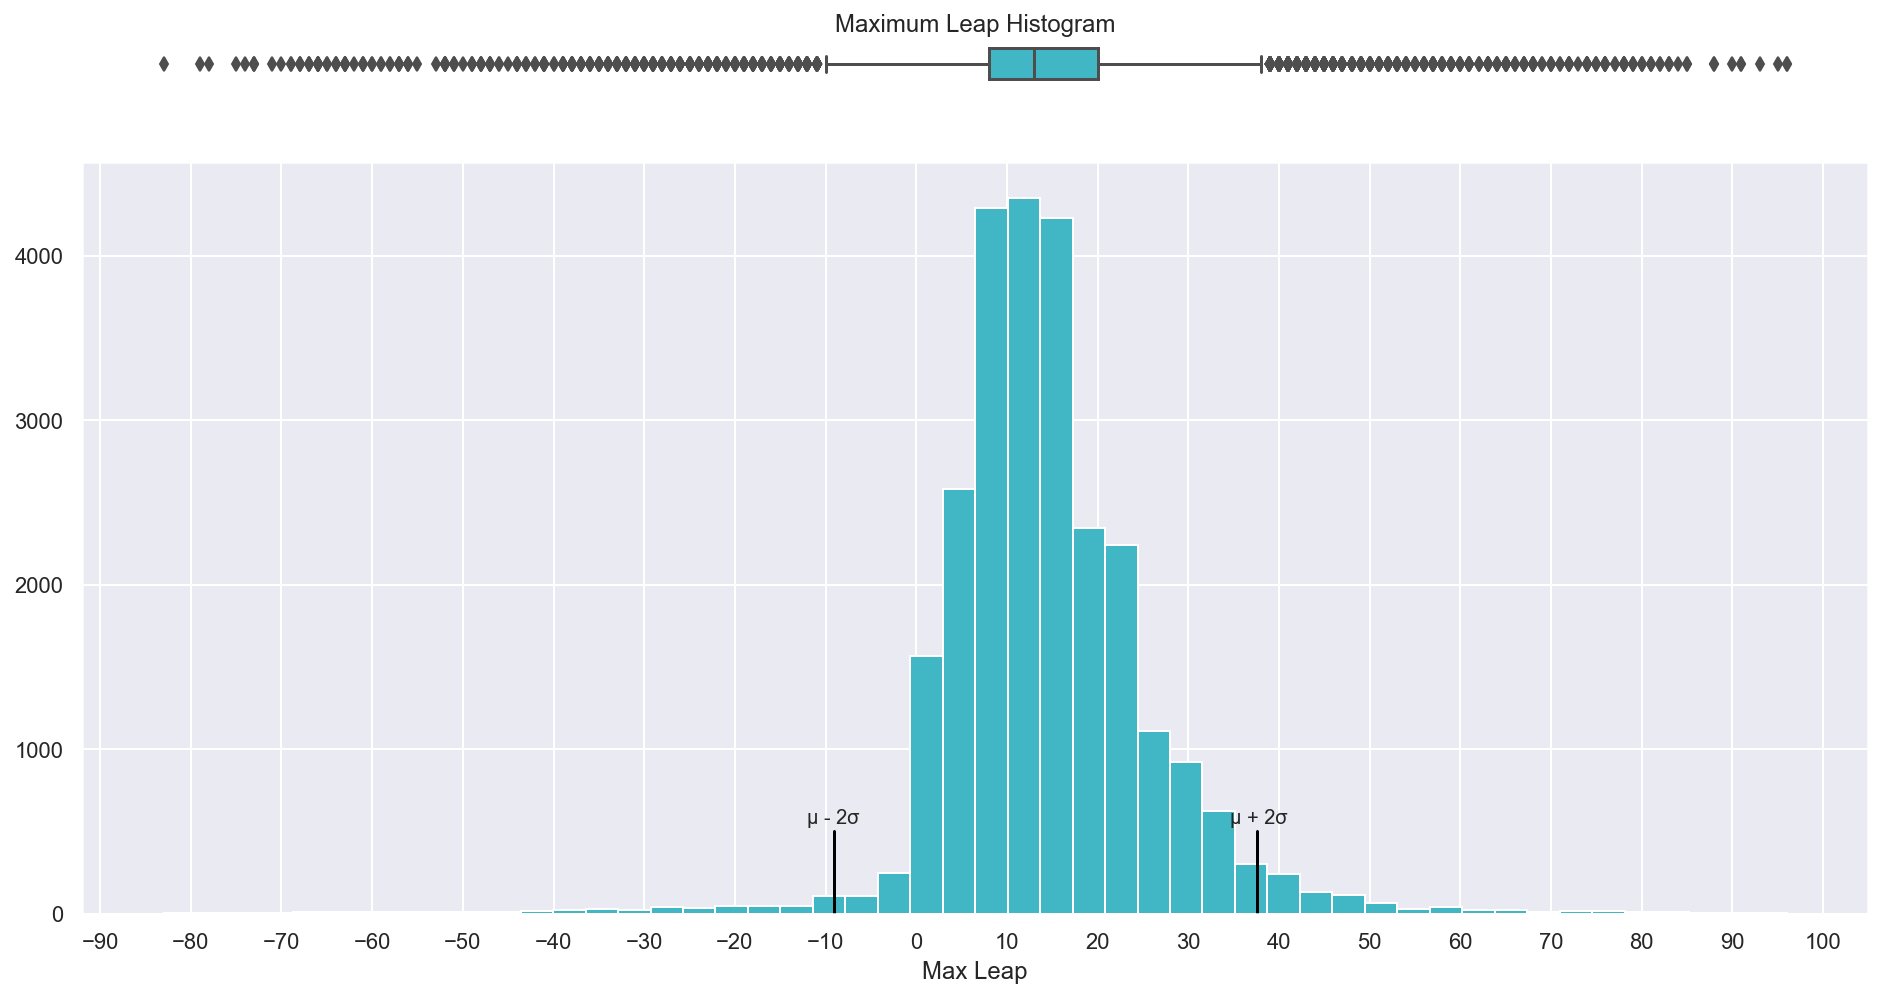

In [21]:
x = hot100_uniq['max_leap'].dropna()

ax_box, ax_hist = create_hist(x,std=True,xticks=(-100,100,10))

_ = ax_box.set_title('Maximum Leap Histogram')
_ = ax_hist.set_xlabel('Max Leap')

We see that the median leap was just above 10 positions and that we can generally expect for most titles to leap at most between 7-19 places. We also can see that leaps beyond the 38 are generally rare, so are negative maximum leaps beyond -9 (i.e. titles that consistently fell in position from their initial entry).

We can also see that generally a title moves up at some point during their time on the Hot 100.

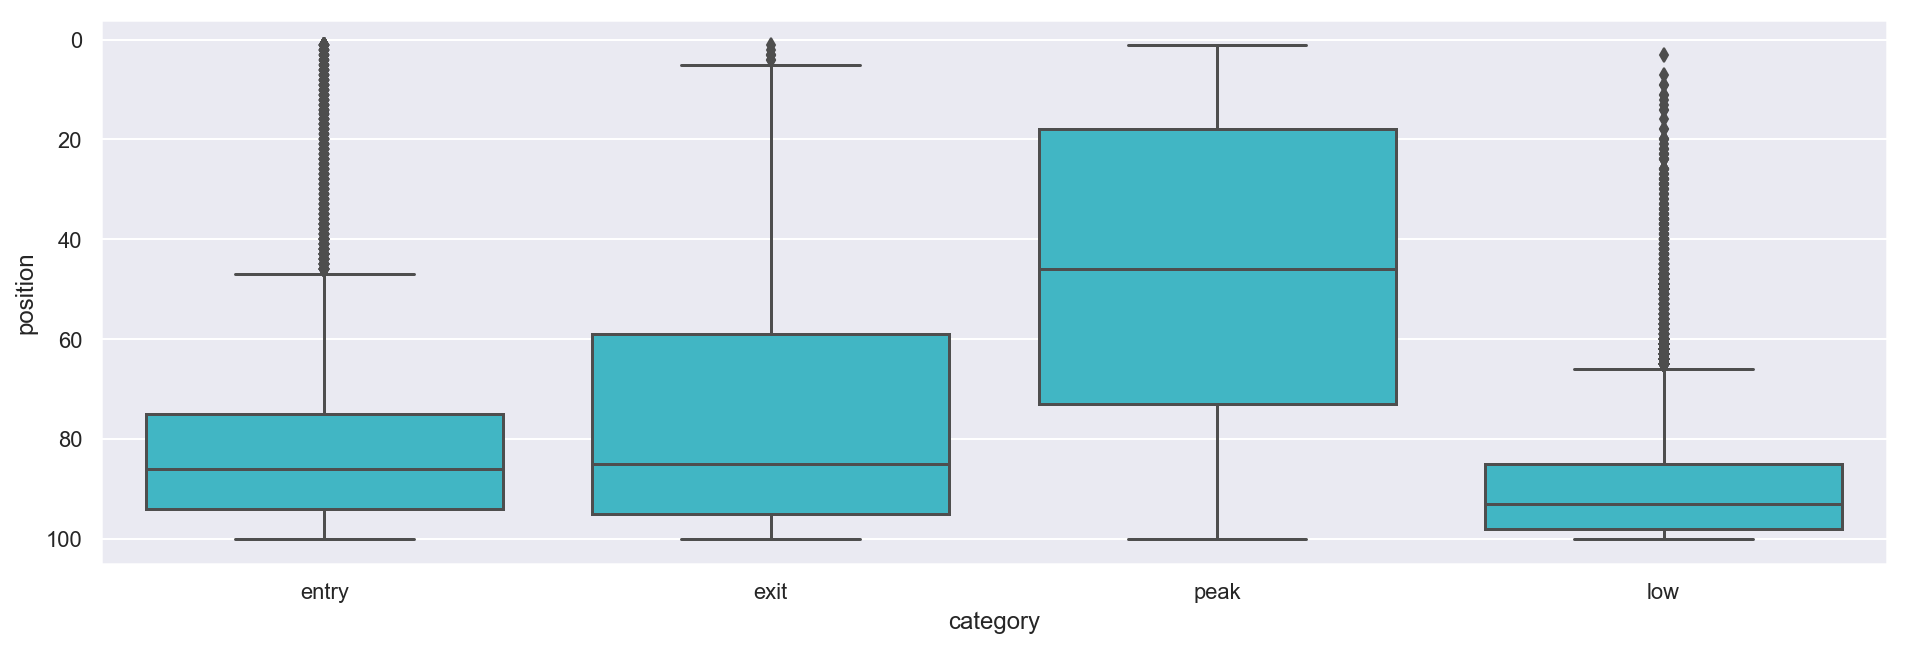

In [22]:
fig = plt.figure(figsize=(16,5))
hot100_pos = hot100_uniq.loc[:,['entry','exit','peak','low']]
hot100_pos_melt = pd.melt(hot100_pos)
hot100_pos_melt.columns = ['category','position']
_ = sns.boxplot(x="category", y="position", data=hot100_pos_melt,color=GrayB[0],saturation=1)
_ = plt.gca().invert_yaxis()
                                                  

Generally songs enter and exit the Hot 100 in the lower positions. As expected it is hard to stay higher up on the Hot 100. Less than 50% of songs make it into the coveted Top 40.

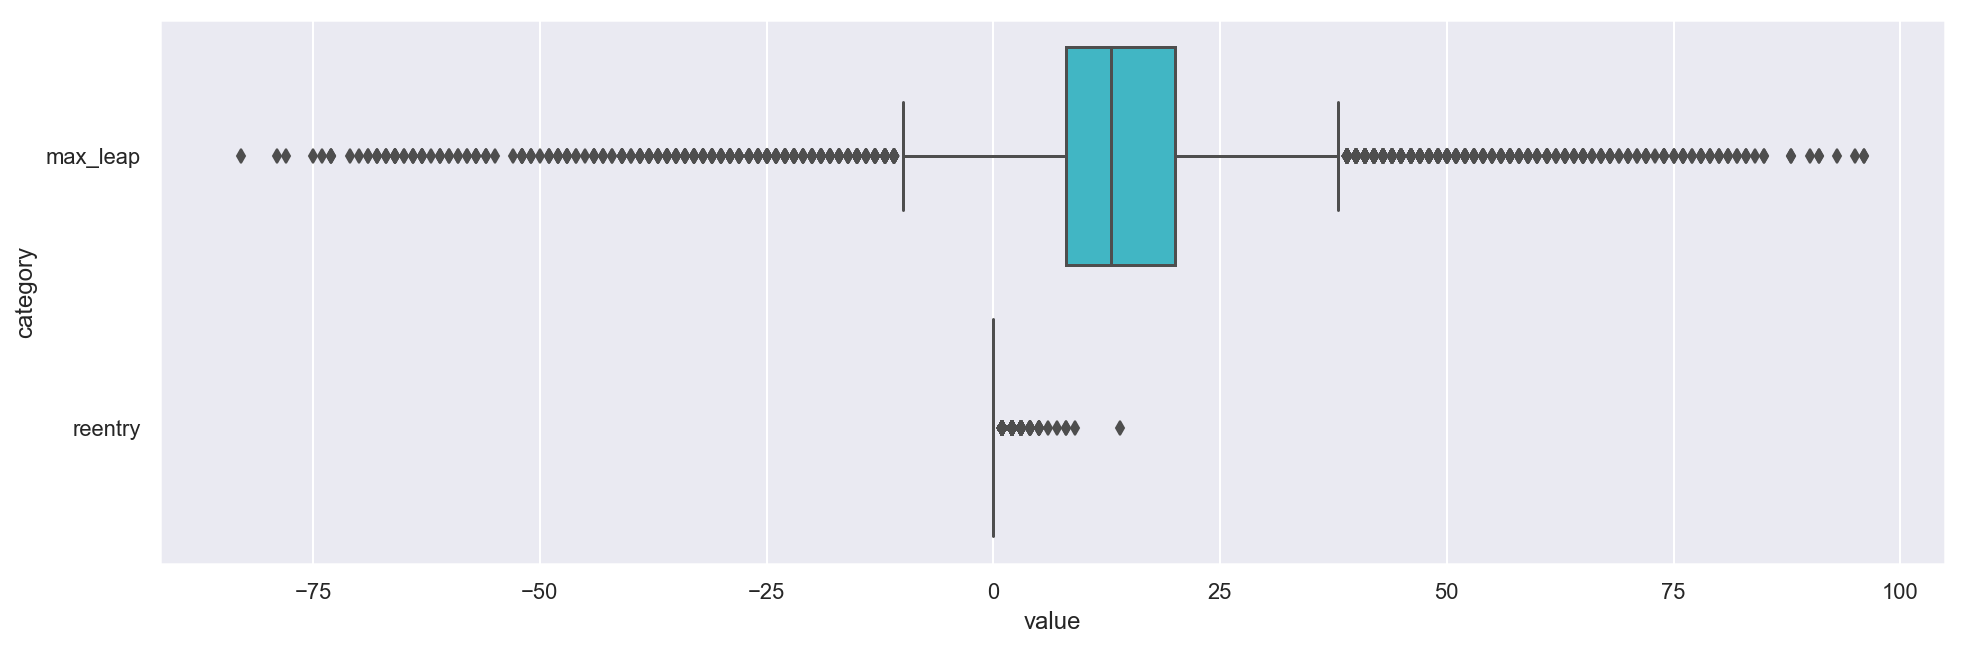

In [23]:
fig = plt.figure(figsize=(16,5))
hot100_meta = hot100_uniq.loc[:,['max_leap','reentry']]
hot100_meta_melt = hot100_meta.melt()
hot100_meta_melt.columns = ['category','value']
_ = sns.boxplot(y='category',x='value',data=hot100_meta_melt,color=GrayB[0],saturation=1)

We can see that consistently falling in position is rare on the Hot 100 (i.e. only few songs have negative max_leaps). There are a total of 6 songs that were able to leap more than 90 positions from one week to another.

In [24]:
biggest_leaps = hot100_uniq.loc[hot100_uniq['max_leap']>90,main_cols_hot100_uniq].sort_values(by='max_leap',ascending=False)
biggest_leaps.head(6)

,,entry_year,exit_year,reentry,streak,ranked,entry,exit,peak,low,max_leap
artist,title,,,,,,,,,,
Kelly Clarkson,My Life Would Suck Without You,2009,2009,0,23,24,97,44,1,97,96.0
Dixie Chicks,Not Ready To Make Nice,2006,2007,2,16,24,28,42,4,100,96.0
Britney Spears,Womanizer,2008,2009,0,22,23,96,45,1,96,95.0
Lady Gaga,Million Reasons,2016,2017,4,8,20,76,41,4,97,93.0
Beyonce & Shakira,Beautiful Liar,2007,2007,0,17,18,94,91,3,94,91.0
LL Cool J Featuring Jennifer Lopez,Control Myself,2006,2006,1,7,11,93,99,4,99,91.0


To visualize the journey of these songs we'll make an attempt at visualizing it.

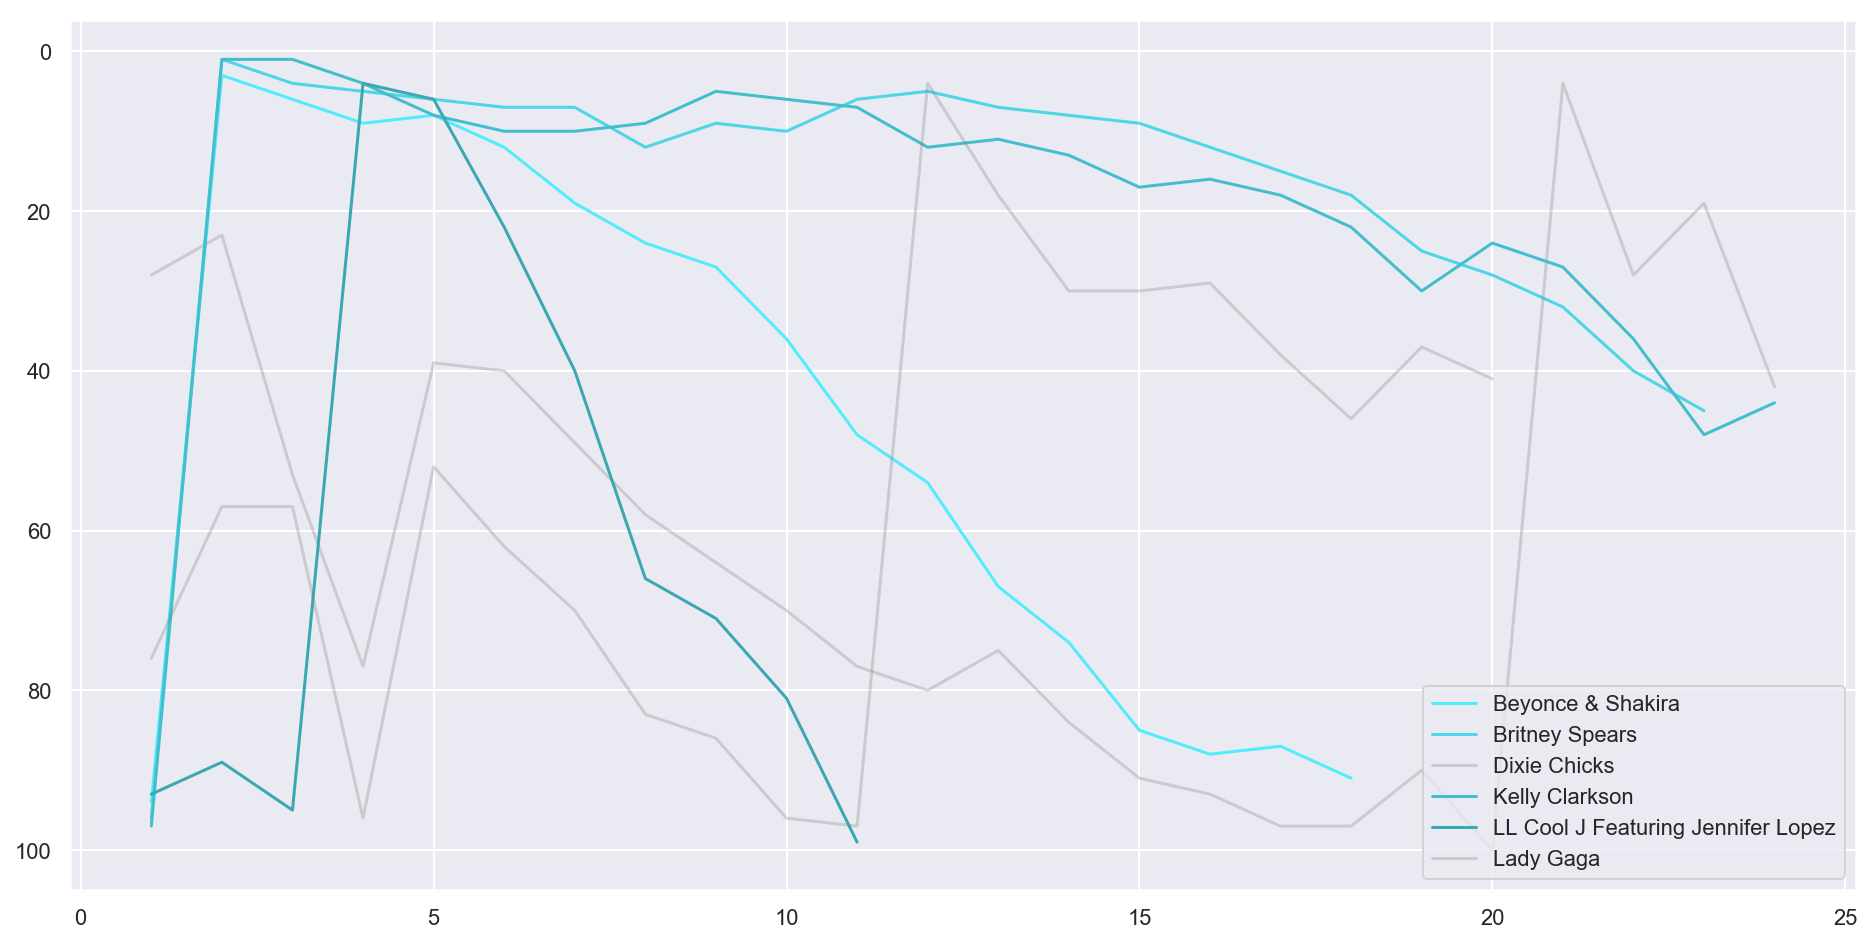

In [25]:
week_rank = pd.merge(hot100.set_index(['artist','title']),biggest_leaps,on=['artist','title'],how='inner').loc[:,['week','rank']]
week_rank_sorted = week_rank.sort_values(by=['artist','title','week'])
colorsB = ['#53ECFC','#4CD6E6','#43BECC','#3BA7B3','#328F99','#2A7780','#225F66','#19474D','#113033','#08181A']
colors_iter = iter(colorsB)
fig = plt.figure(figsize=(16,8))
for i, row_index in enumerate(week_rank_sorted.index.unique()):
    artist, title = row_index
    if artist in ['Dixie Chicks','Lady Gaga','Drake Featuring Nicki Minaj']:
        color = 'gray'
        alpha = 0.3
    else:
        color = next(colors_iter)
        alpha = 1
    plt.plot(week_rank_sorted.loc[(artist,title),'week'],week_rank_sorted.loc[(artist,title),'rank'],label=artist,c=color,alpha=alpha)
_ = plt.gca().invert_yaxis()
_ = plt.legend()

4 out of the songs rise show their max leap to their peak position within the first 4 weeks of their first appearance on the Hot 100. After the initial high is reached there tends to be more or less a steady decline in position. Let's explore this thought further by looking at the time to max leap and average distance to peak position.

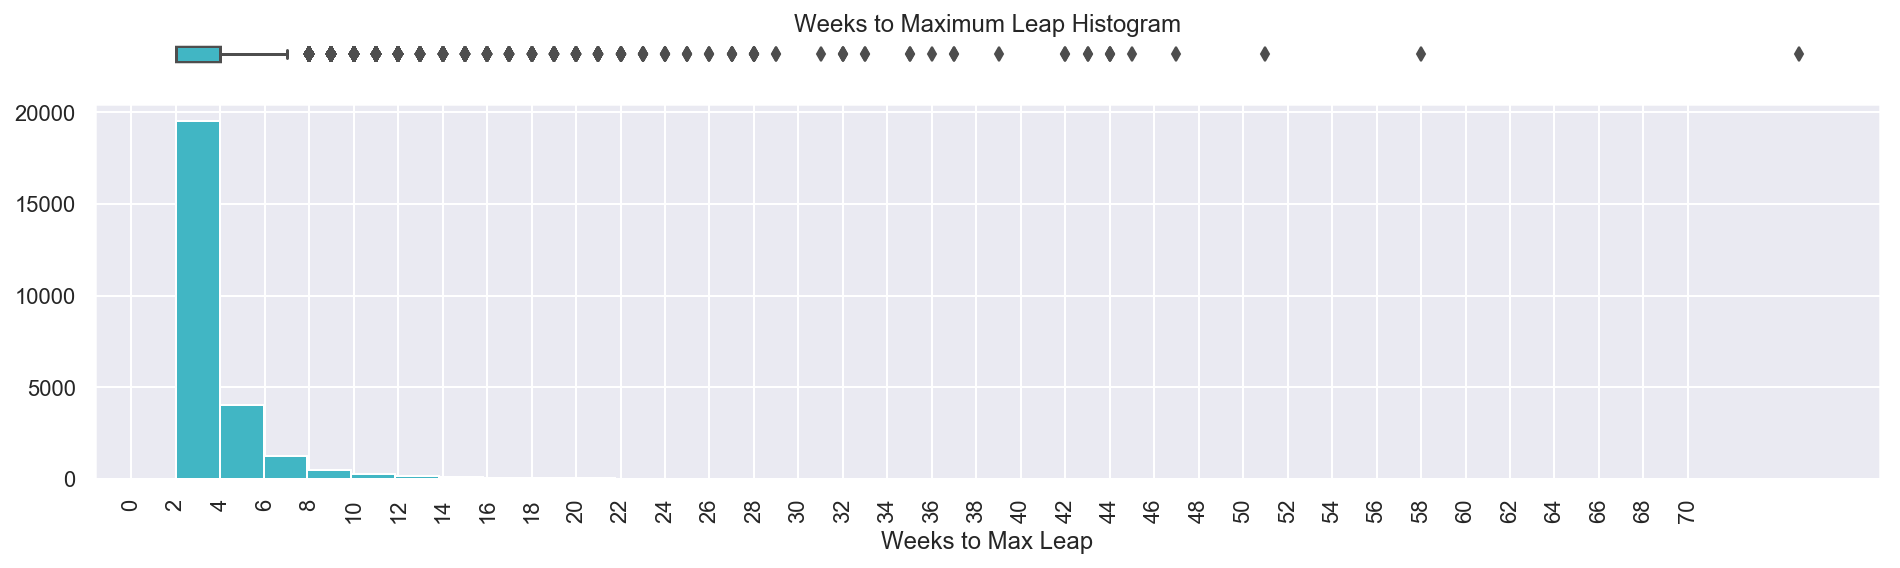

In [26]:
x = hot100_uniq['max_leap_week'].dropna()

ax_box, ax_hist = create_hist(x,xticks=(0,70,2),bins=37,figsize=(16,4))
_ = ax_box.set_title('Weeks to Maximum Leap Histogram')
_ = ax_hist.set_xlabel('Weeks to Max Leap')
_ = plt.xticks(rotation=90)

We can see that the highest jumps occur most often in the second to fourth week of songs making their debut on the Hot 100, indeed. Let's now examine whether this maximum leap is close to the final peak position.

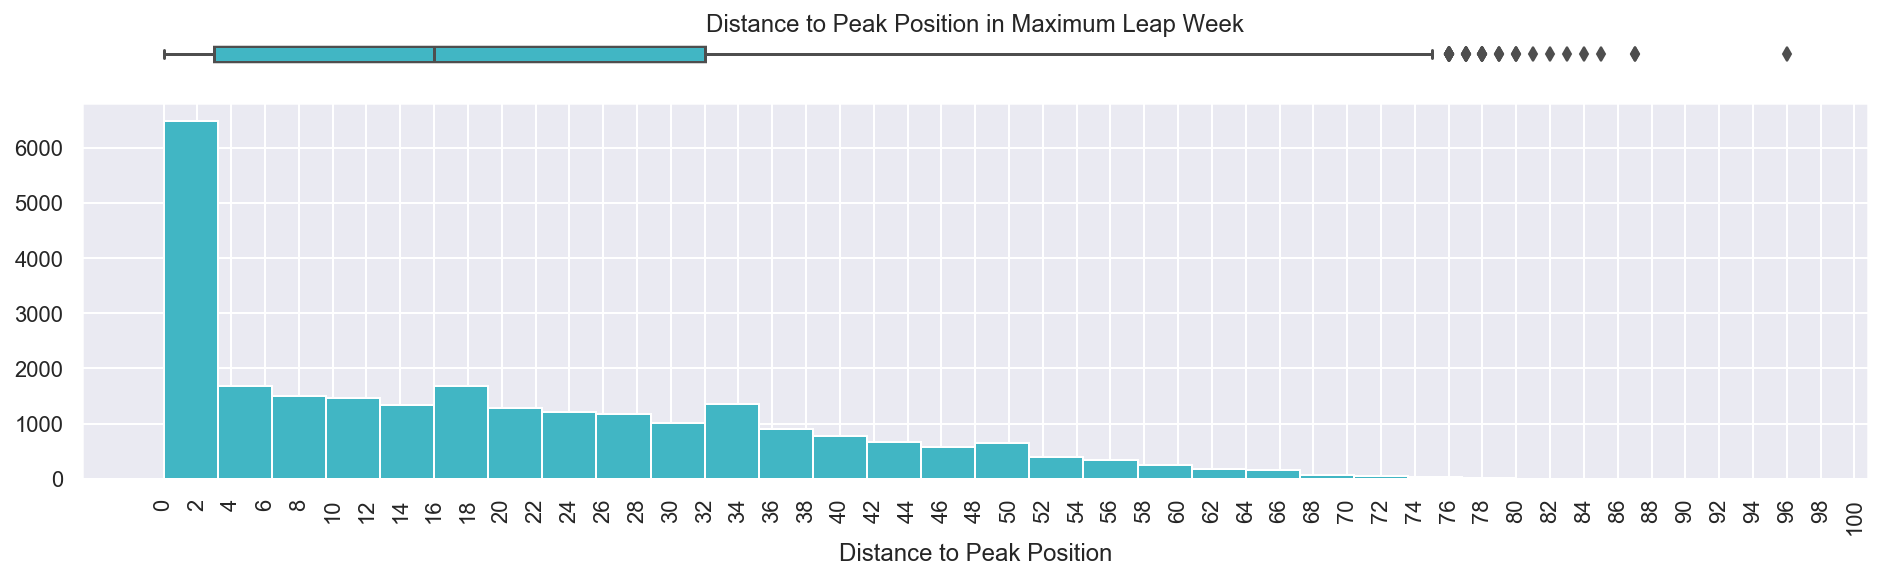

Number of titles that reached their peak position in the weak of their maximum leap: 4375 (i.e. 15.58%)

          dist_peak          peak
count  25273.000000  25273.000000
mean      19.549559     43.111898
std       17.725495     29.457823
min        0.000000      1.000000
25%        3.000000     16.000000
50%       16.000000     41.000000
75%       32.000000     68.000000
max       96.000000    100.000000


In [27]:
# Peak position minus position after maximum leap
hot100_week_rank = hot100.loc[:,['artist','title','week','rank']]
hot100_uniq_leap = pd.merge(hot100_uniq,hot100_week_rank,left_on=['artist','title','max_leap_week'],right_on=['artist','title','week'],how='left').set_index(['artist','title']).sort_index()
hot100_uniq_leap.rename(columns={'week_x':'week','rank':'max_leap_rank'},inplace=True)
hot100_uniq_leap.drop('week_y',axis=1,inplace=True)
hot100_uniq_leap['dist_peak'] = hot100_uniq_leap['max_leap_rank'] - hot100_uniq_leap['peak']

outlier_boundary = get_outlier_boundary(hot100_uniq_leap['max_leap'])
x = hot100_uniq_leap.loc[hot100_uniq_leap['max_leap'] >= 0,['dist_peak','peak']].dropna(subset=['dist_peak'])

ax_box, ax_hist = create_hist(x.dist_peak,xticks=(0,100,2),figsize=(16,4),bins=30)
ax_box.set_title('Distance to Peak Position in Maximum Leap Week')
ax_hist.set_xlabel('Distance to Peak Position')
_ = plt.xticks(rotation=90)
plt.show()

max_leap_peaked = hot100_uniq_leap.loc[hot100_uniq_leap['dist_peak'] == 0,'dist_peak'].count()
print("Number of titles that reached their peak position in the weak of their maximum leap: {} (i.e. {}%)".format(max_leap_peaked,round(max_leap_peaked/len(hot100_uniq_leap)*100,2)))
print()
print(x.describe())

The top 25% fall within 3 positions of their peak and 50% fall within 16 positions. For further examination at the top 25% performers.

### Reentries - The Evergreens Section

There's very few reentries. Most songs that leave the Hot 100 leave for good and only about 4% of the ones that do make a reappearance do so more than twice. In fact, only 6 songs have made a reappearance on the Hot 100 more than 5 times, and they are all seasonal Christmas Evergreens (with one exception 'Unchained Melody' by 'The Righteous Brothers' has made a comeback 14 times).

In [28]:
frequent_reentries = hot100_uniq.loc[hot100_uniq.reentry > 5,main_cols_hot100_uniq].sort_values(by='reentry',ascending=False)
frequent_reentries

,,entry_year,exit_year,reentry,streak,ranked,entry,exit,peak,low,max_leap
artist,title,,,,,,,,,,
The Righteous Brothers,Unchained Melody,1965,1991,14,12,57,72,89,4,97,57.0
Brenda Lee,Rockin' Around The Christmas Tree,1960,2019,9,4,26,64,9,9,89,38.0
Bobby Helms,Jingle Bell Rock,1958,2019,8,4,25,57,8,8,99,28.0
Mariah Carey,All I Want For Christmas Is You,2000,2019,8,5,29,83,3,3,83,54.0
Nat King Cole,The Christmas Song (Merry Christmas To You),1960,2019,7,4,16,100,11,11,100,20.0
Bing Crosby,White Christmas,1958,2019,6,2,15,86,34,12,86,33.0


To finish this initial analysis let's check what was on the Hot 100 on your birthday.

In [289]:
import ipywidgets as widgets

yr = widgets.IntSlider(value=1989,min=1958,max=2019,step=1,description='Year:')
m = widgets.IntSlider(value=10,min=1,max=12,step=1,description='Month:')
d = widgets.IntSlider(value=29,min=1,max=31,step=1,description='Day:')
top = widgets.IntSlider(value=1,min=1,max=100,step=1,description='Top')

submit = widgets.Button(description="Show Hot 100")
submit.on_click(handle_submit)

def fetch_list(yr,m,d,top=1):
    birthday_hit = hot100.loc[hot100['rank'] <= top,:]
    return birthday_hit.loc[(birthday_hit['year'] == yr) & (birthday_hit['month'] == m) & (birthday_hit['day'] >= d) & (birthday_hit['day'] < (d + 7)),main_cols_hot100]

def get_birthday_top(yr,m,d,top):
    b_list = fetch_list(yr,m,d,top)
    if len(b_list) < 1:
        d = 1
        if m < 12:
            m += 1
        else:
            m = 1
            yr += 1
        b_list = fetch_list(yr,m,d,top)
    return b_list.set_index(['artist','title'])

# Create Output Variable and Context Manager (necessary to clear old outputs)
out = widgets.Output(layout={'border': '1px solid black'})
def handle_submit(sender):
    out.clear_output()
    with out:
        display(get_birthday_top(yr.value,m.value,d.value,top.value))

print('Check the Hot 100 on your Birthday')
# Display Birthday sliders
display(yr)
display(m)
display(d)
display(top)
# Display Submit Button and Output
display(submit)
display(out)

Check the Hot 100 on your Birthday


IntSlider(value=1989, description='Year:', max=2019, min=1958)

IntSlider(value=10, description='Month:', max=12, min=1)

IntSlider(value=29, description='Day:', max=31, min=1)

IntSlider(value=1, description='Top', min=1)

Button(description='Show Hot 100', style=ButtonStyle())

Output(layout=Layout(border='1px solid black'))

# Make up of Hits

To dive deeper into the actual make up of a song we'll have a look at the audio features of a hit by looking at its audio signature. Let's start with a few descriptive metrics

In [120]:
GrayP = ['#b440c4',"gray","black"]
sns.set_palette(GrayP)

colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']

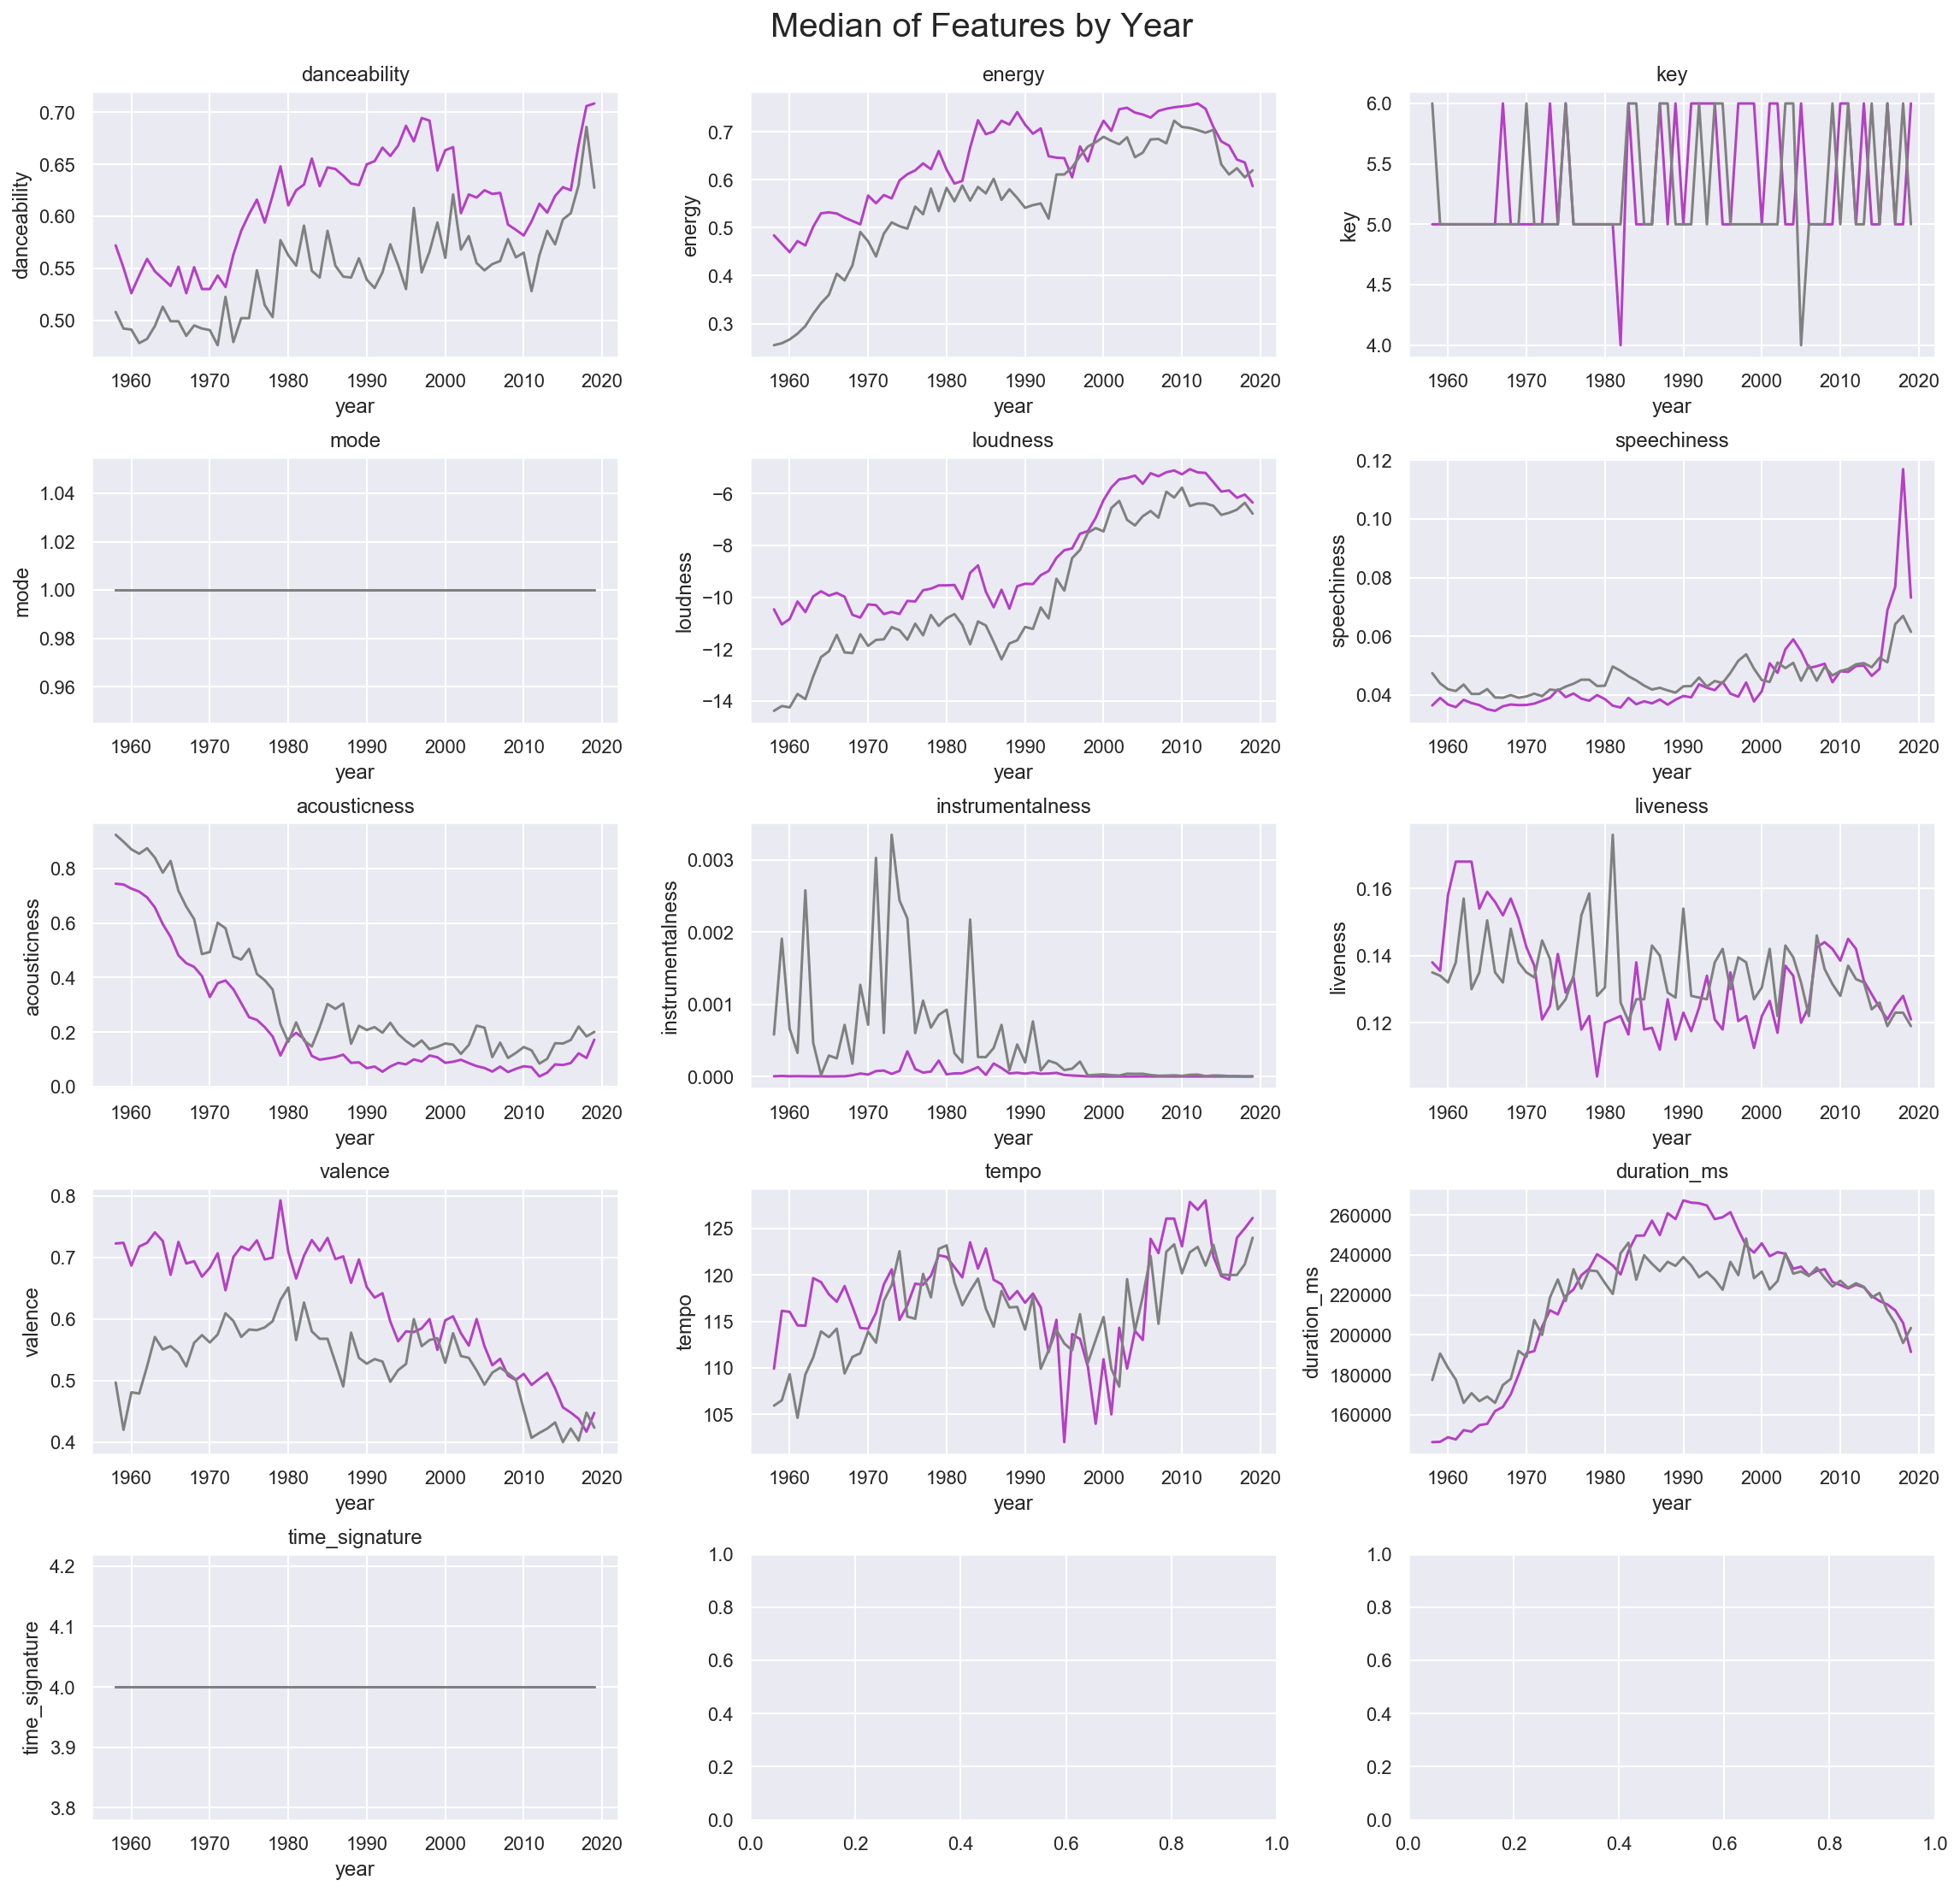

There are 34671 songs and 16 features


In [121]:
import math

features = np.array(['danceability', 'energy', 'key', 'mode','loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms','time_signature'])
analysis_train = train.loc[:,main_cols_analysis]

def plot_feature_by(hits,nhits,feature,ax,by='year'):
    # Group plus dataset and calc median
    hits_by = hits.groupby(by)
    hits_by_median = hits_by.median()

    # Group minus dataset and calc median
    nhits_by = nhits.groupby(by)
    nhits_by_median = nhits_by.median()

    _ = ax.plot(hits_by_median.index,hits_by_median[feature])
    _ = ax.plot(nhits_by_median.index,nhits_by_median[feature])
    _ = ax.set_title(feature)
    _ = ax.set_xlabel('year')
    _ = ax.set_ylabel(feature)
    
def plot_feature(hits,nhits,feature,ax):
    _ = ax.scatter(hits.year,hits[feature],s=1)
    _ = ax.scatter(nhits.year,nhits[feature],s=1)
    _ = ax.set_title(feature)
    _ = ax.set_xlabel('year')
    _ = ax.set_ylabel(feature)
    

def by_year_median(hits,nhits,features,scatter=False):
    total = len(features)
    
    rows = math.ceil(total/3)
    fig, axes = plt.subplots(rows,3,figsize=(16,rows * 3))
    
    _ = fig.suptitle('Median of Features by Year',fontsize=20,y=1.02)
    
    feature_ct = 0
    for col in axes:
        if len(axes) > 1:
            for ax in col:
                if scatter:
                    try:
                        plot_feature(hits,nhits,features[feature_ct],ax)
                    except:
                        pass
                else:
                    try:
                        plot_feature_by(hits,nhits,features[feature_ct],ax,by='year')
                    except:
                        pass
                feature_ct += 1
        else:
            if scatter:
                plot_feature(hits,nhits,features[feature_ct],ax)
            else:  
                plot_feature_by(hits,nhits,features[feature_ct],ax,by='year')
            feature_ct += 1
    _ = plt.tight_layout()
    return fig, axes

fig, axes = by_year_median(hits,nhits,features)
plt.show()

print("There are {} songs and {} features".format(analysis_train.shape[0],analysis_train.shape[1]))

In [122]:
analysis_train.head()

,,id,hit,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
artist,title,,,,,,,,,,,,,,,,
Asleep At The Wheel,Walking The Floor Over You,2QYx89g0CWgg7gBuOsnAZ5,False,0.568000,0.847,151213.0,0.403,0.000005,11.0,0.0723,-13.817,1.0,13.0,0.0425,100.472,4.0,0.965
A. M. Rajah + Jikki,Thanga Nilavil,1JHuBlcmJGucIjFSXAsXvv,False,0.971000,0.655,192827.0,0.512,0.131000,2.0,0.3770,-7.723,0.0,0.0,0.0431,124.392,3.0,0.660
Arpeggio,Love And Desire (Part I),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dead Confederate,The Rat,49bIzVlvSzJZGZqkXyQvQ5,False,0.000884,0.357,315333.0,0.804,0.168000,9.0,0.1060,-5.619,0.0,29.0,0.0598,181.001,4.0,0.238
Lou Rawls,When We Get Old,3bPwu28B8rk1cIvPnP32GK,False,0.832000,0.549,133573.0,0.913,0.000024,4.0,0.4410,-3.175,0.0,0.0,0.1260,83.445,4.0,0.826


In [123]:
def get_analysis(selection_df):
    return combined.loc[selection_df.index,:]

longest_streak_analysis = get_analysis(longest_streak)
longest_nr_1_analysis = get_analysis(longest_nr_1)
biggest_leaps_analysis = get_analysis(biggest_leaps)

In [124]:
features = ['year','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']
"""
for feature in features:
    print(feature)
    fig, ax = plt.subplots(2,figsize=(15,3))
    plt.title(feature)
    max_x = hits.loc[:,feature].max()
    min_x = hits.loc[:,feature].min()
    
    plt.xlim(min_x,max_x)
    
    plt.subplot(2,1,1,sharex=ax[0])
    sns.boxplot(nhits.loc[:,feature])
    plt.tight_layout()

    plt.subplot(2,1,2,sharex=ax[0])
    sns.boxplot(hits.loc[:,feature])
    plt.tight_layout()
    plt.show()
"""

'\nfor feature in features:\n    print(feature)\n    fig, ax = plt.subplots(2,figsize=(15,3))\n    plt.title(feature)\n    max_x = hits.loc[:,feature].max()\n    min_x = hits.loc[:,feature].min()\n    \n    plt.xlim(min_x,max_x)\n    \n    plt.subplot(2,1,1,sharex=ax[0])\n    sns.boxplot(nhits.loc[:,feature])\n    plt.tight_layout()\n\n    plt.subplot(2,1,2,sharex=ax[0])\n    sns.boxplot(hits.loc[:,feature])\n    plt.tight_layout()\n    plt.show()\n'

In [125]:
top1 = hits.peak == 1
top10 = hits.peak <= 10
top40 = hits.peak <= 40
top100 = hits.peak <= hits.peak.max()

categories = {'top1':top1,'top10':top10,'top40':top40,'top100':top100}
features = ['year','popularity','peak','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']

"""
for feature in features:
    print(feature)
    fig, ax = plt.subplots(1,4,figsize=(18,6))
    plt.title(feature)
    max_x = hits.loc[:,feature].max()
    min_x = hits.loc[:,feature].min()
    for i, category in enumerate(zip(categories.keys(),categories.values())):
        category_name = category[0]
        cond = category[1]
        plt.subplot(1,4,i + 1)
        plt.hist(hits.loc[cond,feature])
        plt.xlim(min_x,max_x)
        plt.xlabel(category_name)
    plt.show()
"""

'\nfor feature in features:\n    print(feature)\n    fig, ax = plt.subplots(1,4,figsize=(18,6))\n    plt.title(feature)\n    max_x = hits.loc[:,feature].max()\n    min_x = hits.loc[:,feature].min()\n    for i, category in enumerate(zip(categories.keys(),categories.values())):\n        category_name = category[0]\n        cond = category[1]\n        plt.subplot(1,4,i + 1)\n        plt.hist(hits.loc[cond,feature])\n        plt.xlim(min_x,max_x)\n        plt.xlabel(category_name)\n    plt.show()\n'

In [196]:
features = ['acousticness','loudness','year','instrumentalness','danceability']
predictor = ['hit']

In [197]:
from sklearn.model_selection import train_test_split

Xy_train = train.copy().loc[:,features + predictor].dropna()
X = Xy_train.drop('hit',axis=1)
y = Xy_train['hit']

X_tune, X_hold, y_tune, y_hold = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.33, random_state=42)

5 0.654508561626076
100 0.6477077076995176
200 0.6578949472147086
300 0.6563619193816407
400 0.6560956856154361
500 0.658312904528404
600 0.6561177252335818
700 0.6557962987489552
800 0.6567143034961349
900 0.656872878099809


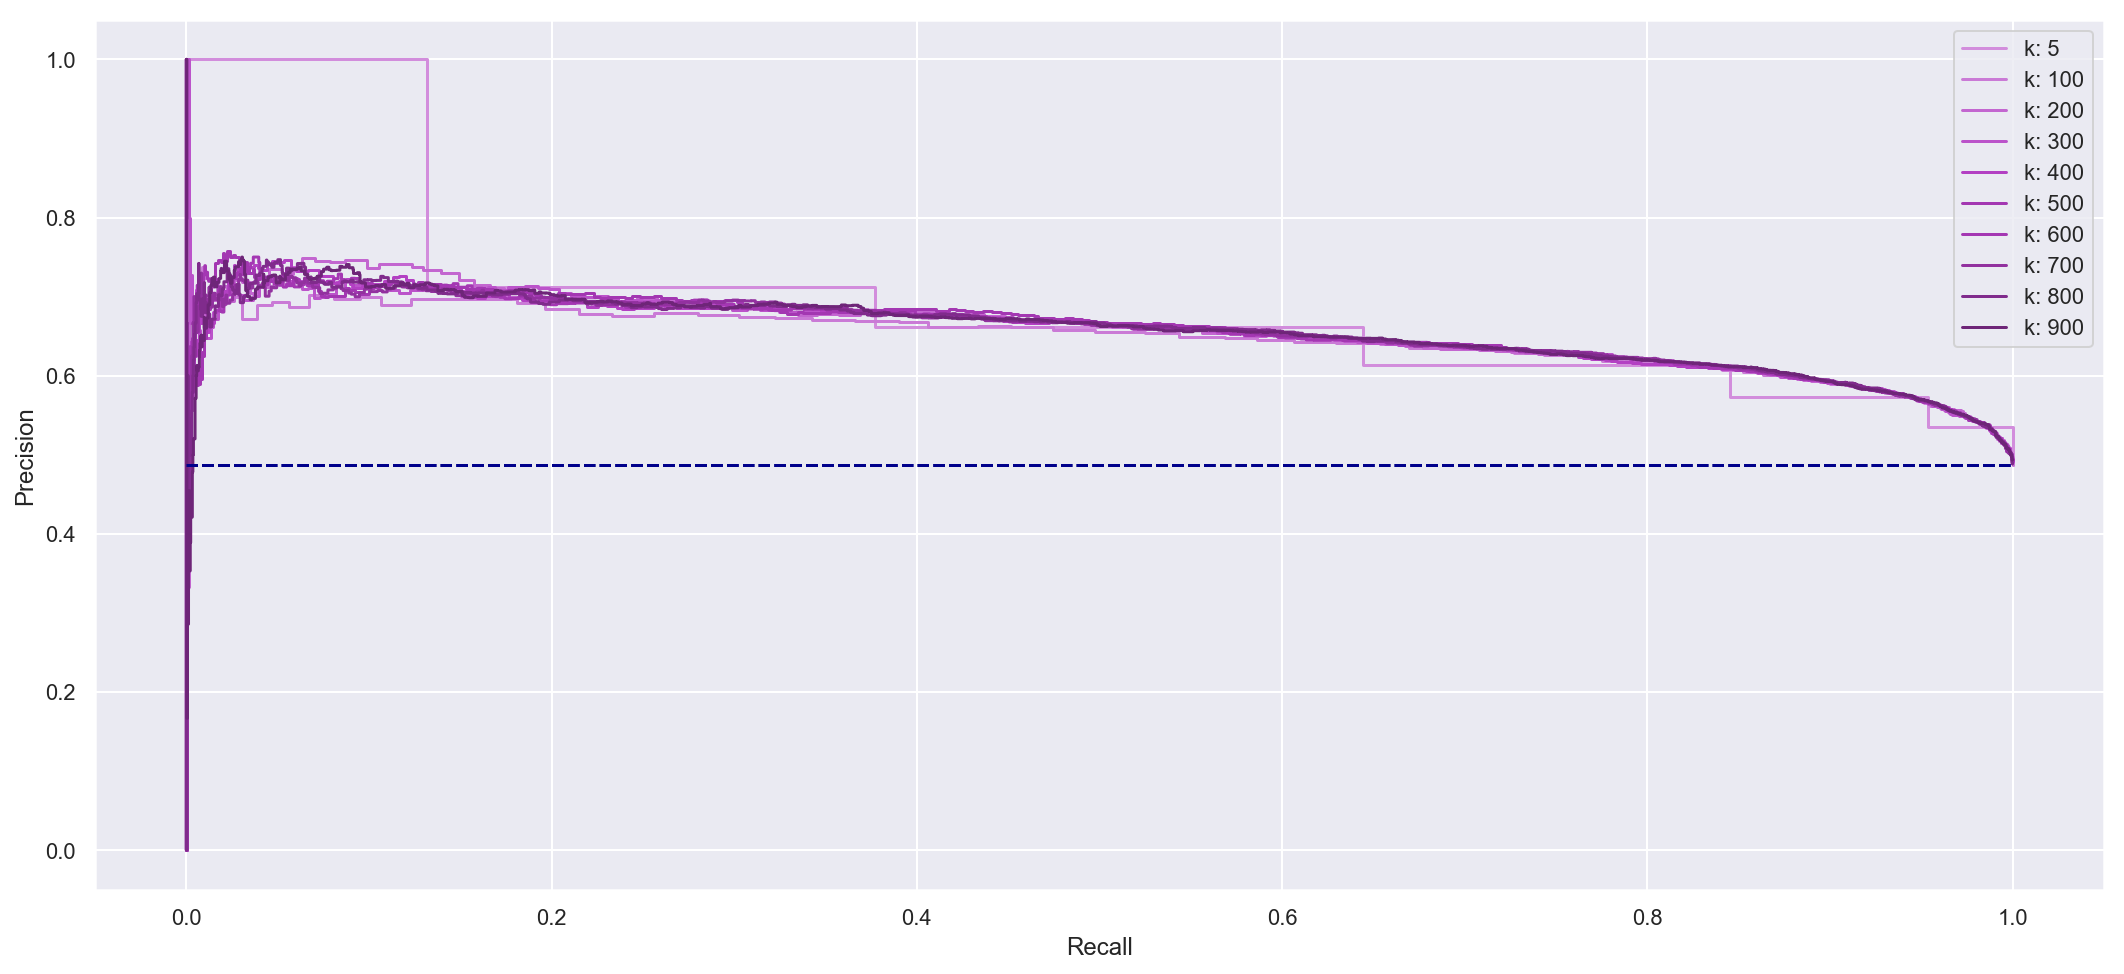

In [205]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# The function
def plot_pr_curve(y_test,y_pred,hyperparameter,color):
    precision,recall,threshold = precision_recall_curve(y_test,y_pred)
    
    _ = plt.step(recall,precision,label='{}: {}'.format(hyperparameter[0],hyperparameter[1]),color=color)
    dumb = len(y_test[y_test>0])/len(y_test)
    _ = plt.plot([0,1],[dumb,dumb], color='darkblue', linestyle='--')
    _ = plt.xlabel('Recall')
    _ = plt.ylabel('Precision')
    
    plt.legend()
    
    pr_auc = auc(recall,precision)
    return pr_auc

estimators = np.arange(0,1000,100)
estimators[0] = 5

fig = plt.figure(figsize=(18,8))

for i,k in enumerate(estimators):
    rf = RandomForestClassifier(n_estimators=k)
    rf.fit(X_train,y_train)

    y_test_pred = rf.predict_proba(X_test).T[1]
    hyperparameter = ('k',k)
    pr_auc = plot_pr_curve(y_test,y_test_pred,hyperparameter,colorsP[i])
    print(k, pr_auc)
plt.show()

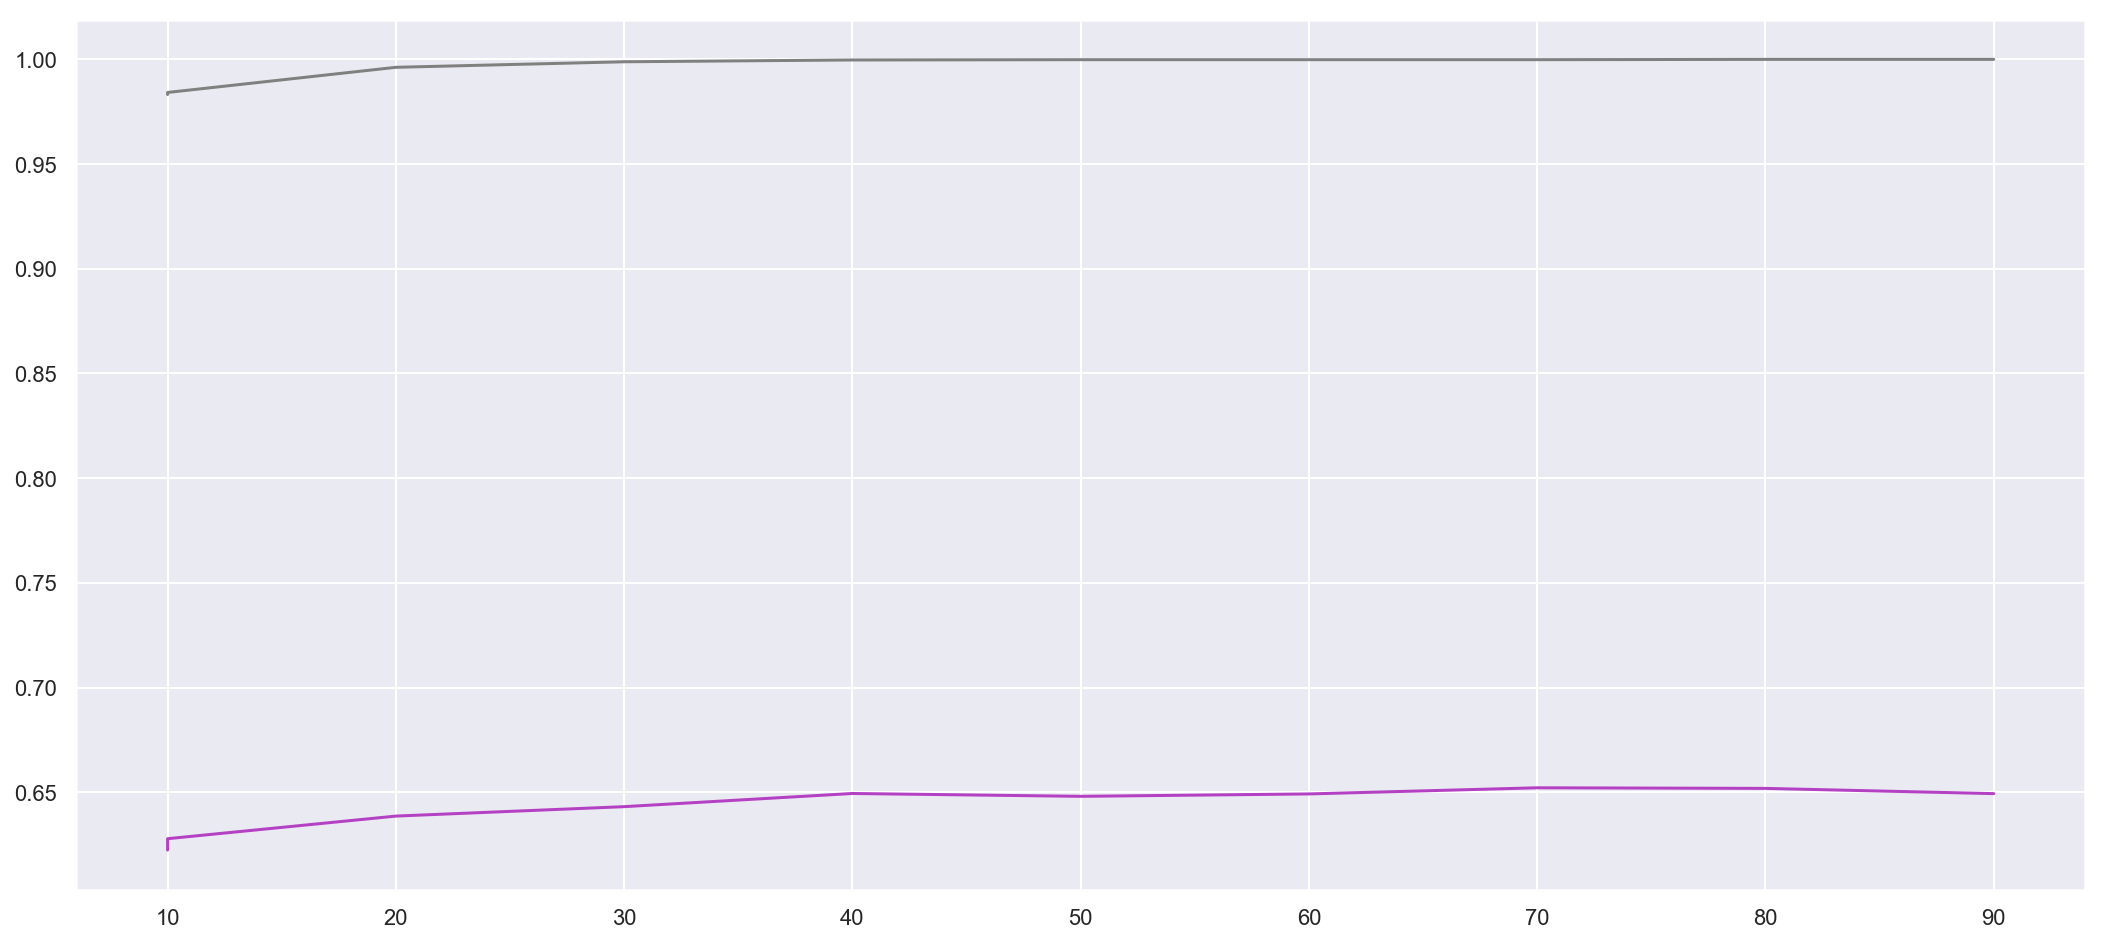

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

estimators = np.arange(0,100,10)
estimators[0] = 10
train_accuracy = np.empty(len(estimators))
test_accuracy = np.empty(len(estimators))

fig = plt.figure(figsize=(18,8))

for i,k in enumerate(estimators):
    rf = RandomForestClassifier(n_estimators=k)

    rf.fit(X_train[features],y_train)
    
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    train_accuracy[i] = accuracy_score(y_train,y_train_pred)
    test_accuracy[i] = cross_val_score(rf,X_train,y_train,cv=5).mean()
    
plt.plot(estimators,test_accuracy,label='Testing Accuracy')
plt.plot(estimators,train_accuracy,label='Training Accuracy')

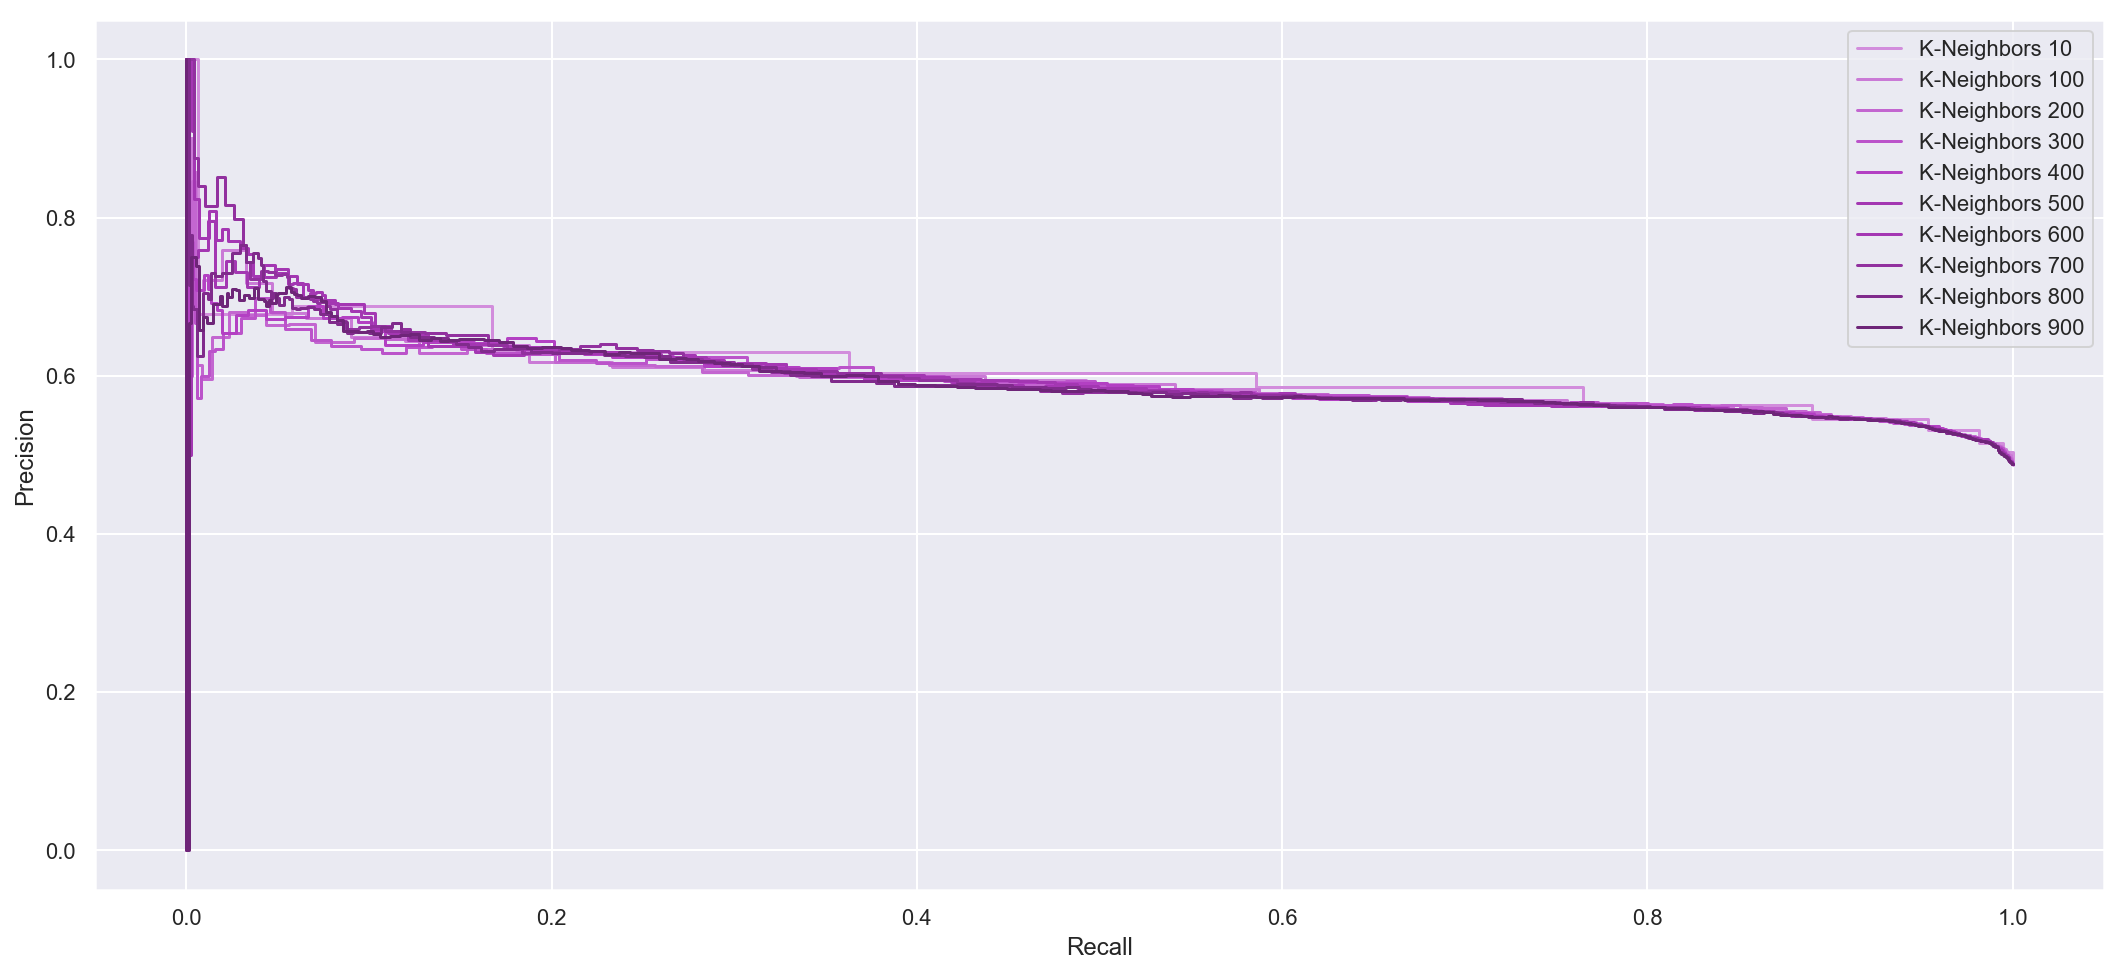

In [200]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve

neighbors = np.arange(0,1000,100)
neighbors[0] = 10
fig = plt.figure(figsize=(18,8))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train[features],y_train)
    
    y_test_pred = knn.predict_proba(X_test[features])

    precision,recall,threshold = precision_recall_curve(y_test,y_test_pred.T[1])
    
    _ = plt.step(recall,precision,label='K-Neighbors {}'.format(k),color=colorsP[i])

_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
plt.legend()

In [203]:
y_pred = rf.predict(X_test[features])
accuracy_score(y_test,y_pred)

0.6552975326560232

1 0.5847813409800413
10 0.6443706963657899
20 0.6463304772851757
30 0.6436208066548486
40 0.6478433682885567


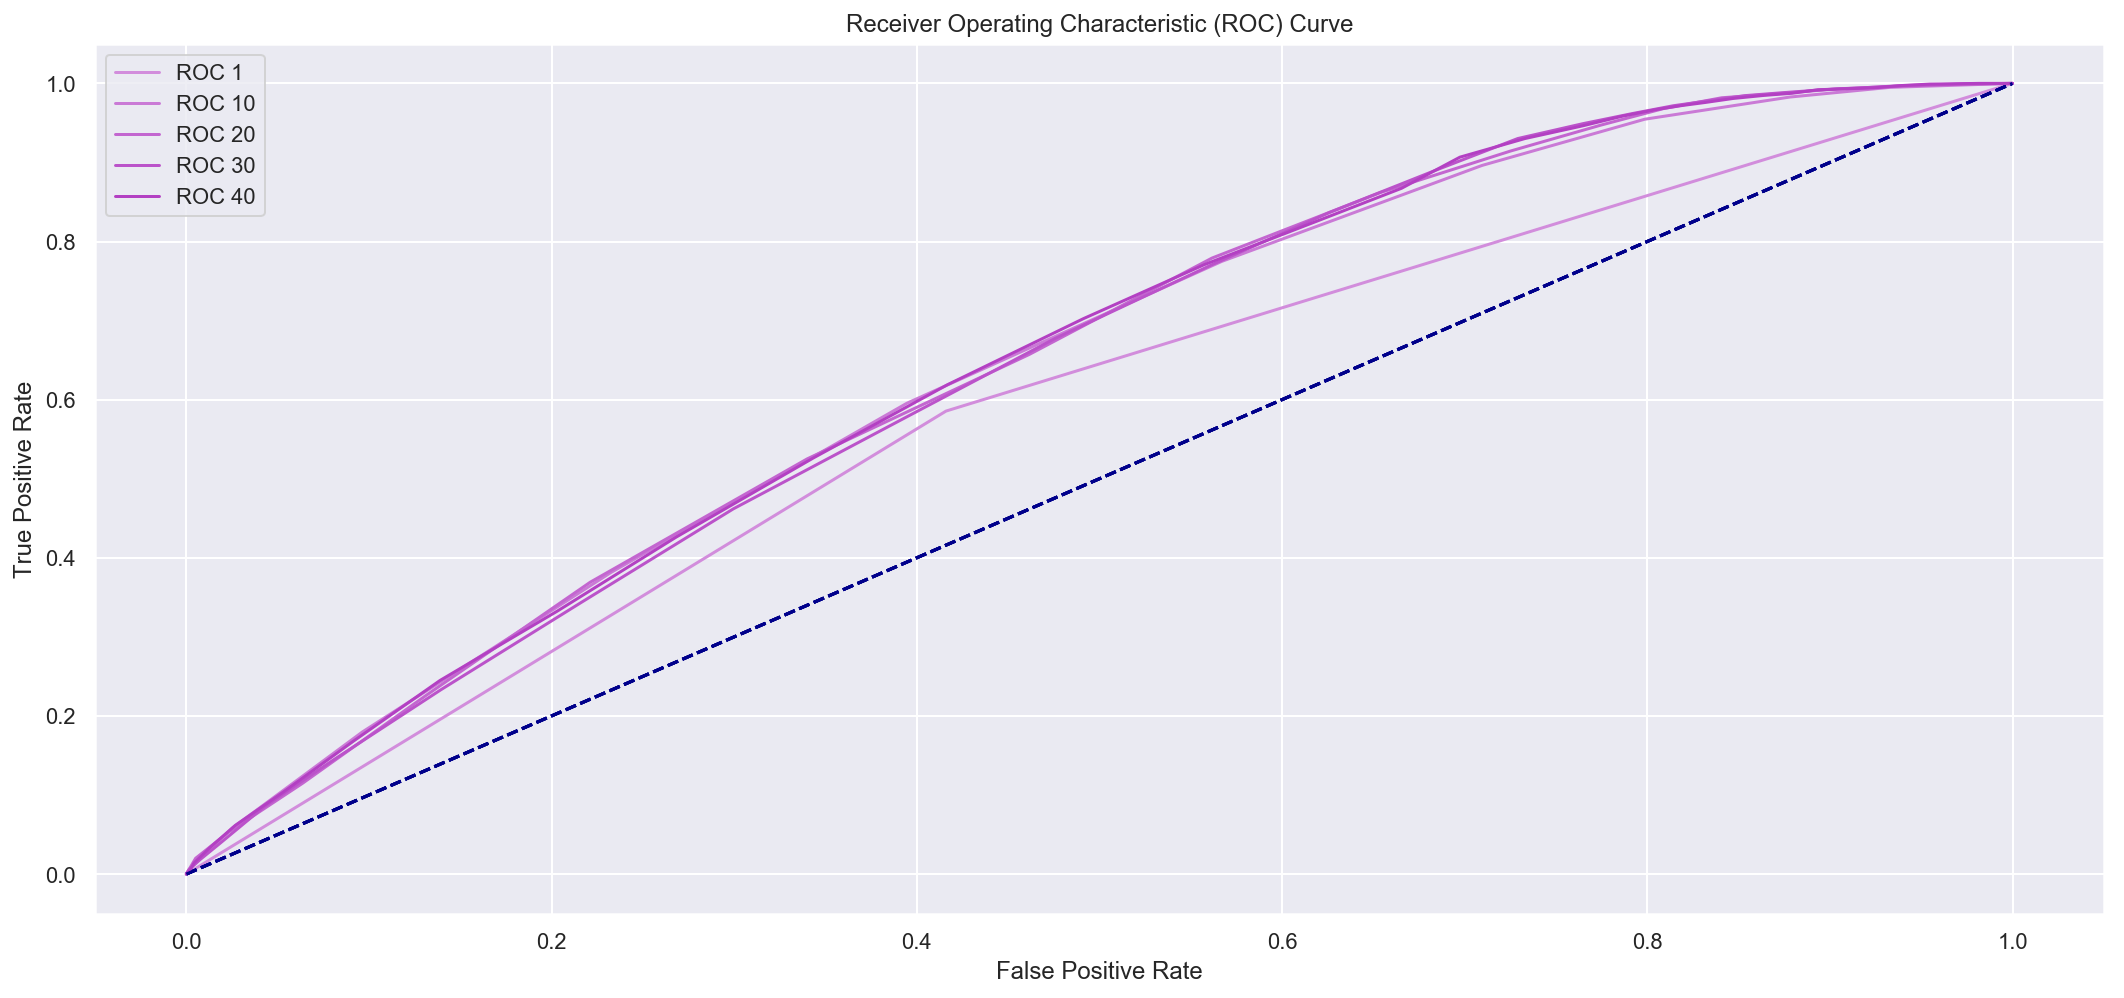

1 0.6795362023969147
10 0.6034377582784958
20 0.6009451285786914
30 0.5939703722774976
40 0.6004712275960383


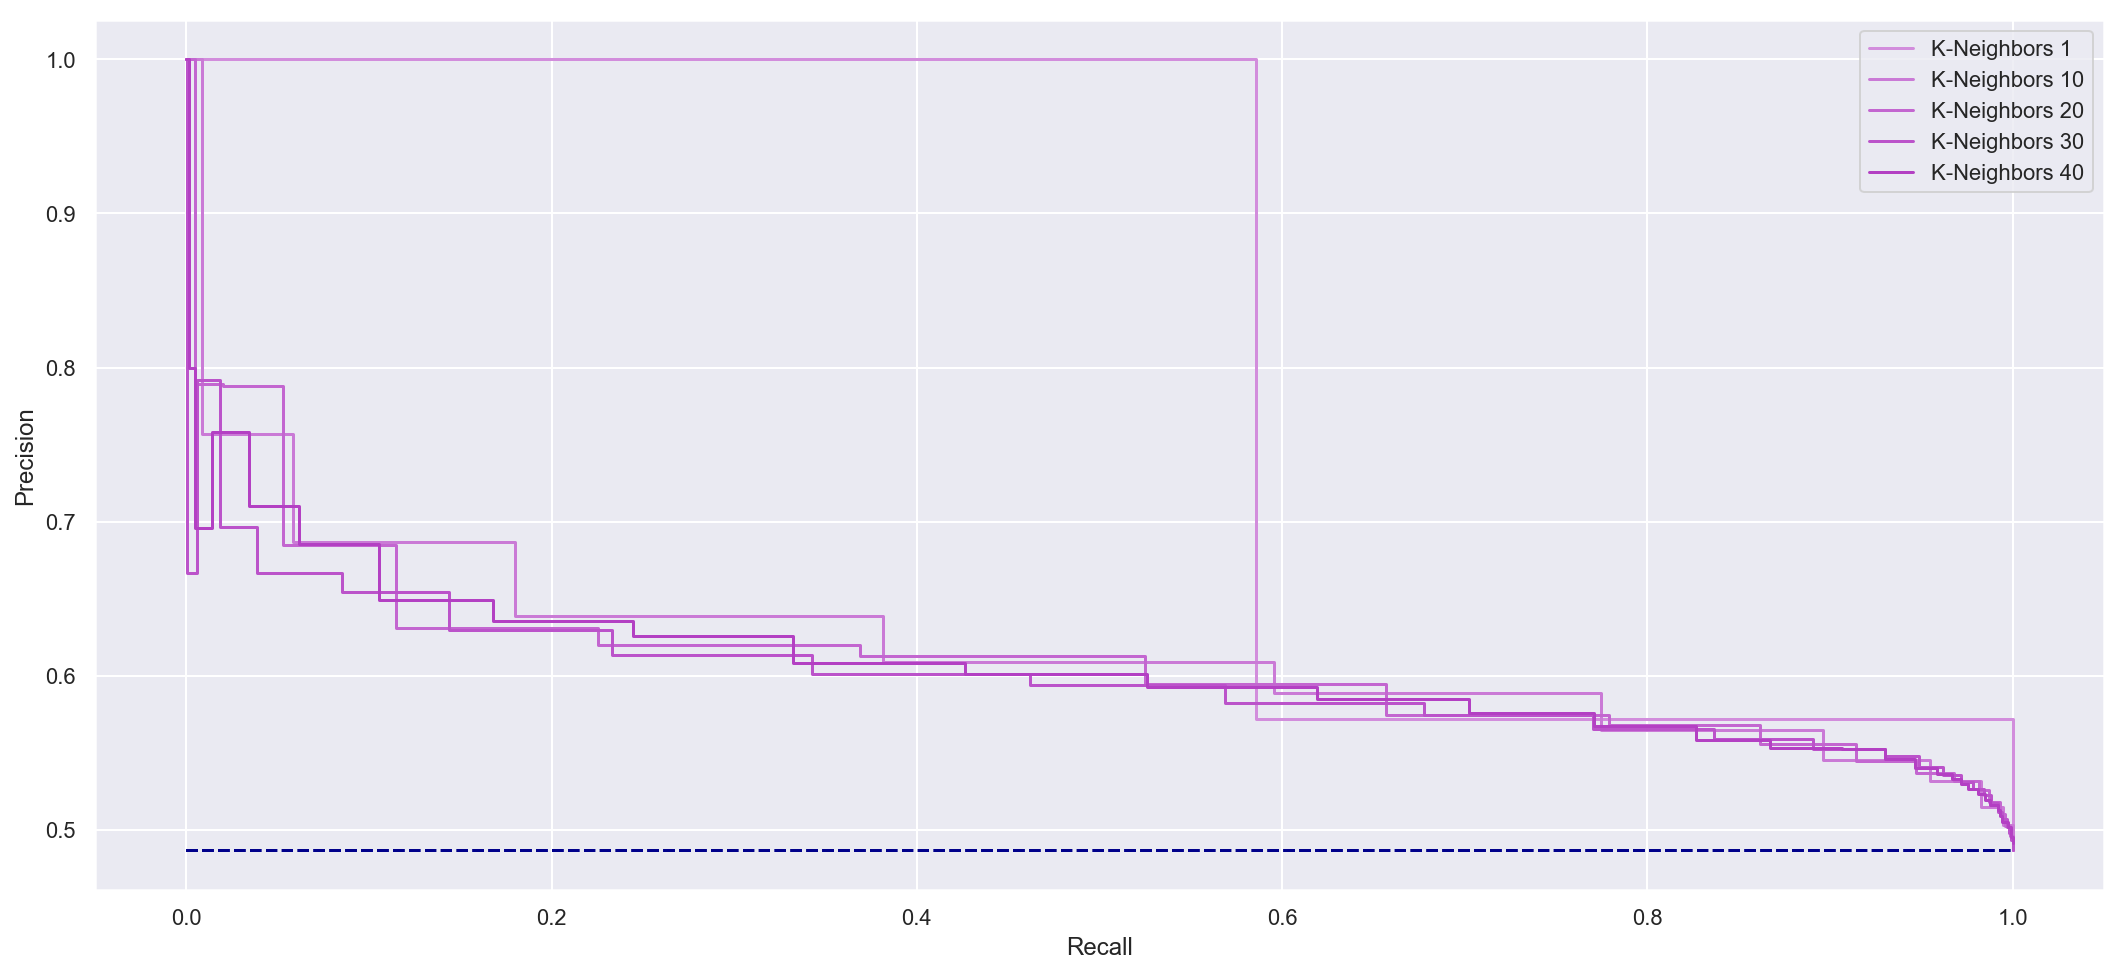

In [184]:
# Template for ROC_CURVE and ROC_AUC - only works if there are X_train,X_test,y_train and y_test variables available

from sklearn.metrics import roc_curve, roc_auc_score, auc

# The function
def plot_roc_curve(y_test, y_pred, hyperparameter,color):  
    """
        Plot Roc Curve using predictions or probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    _ = plt.plot(fpr, tpr, label='ROC {}'.format(hyperparameter),color=color)
    _ = plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
    roc_auc = roc_auc_score(y_test,y_pred)
    return roc_auc


from sklearn.metrics import roc_curve, roc_auc_score

# The function
def plot_pr_curve(y_test,y_pred,hyperparameter,color):
    precision,recall,threshold = precision_recall_curve(y_test,y_pred)
    
    _ = plt.step(recall,precision,label='K-Neighbors {}'.format(k),color=color)
    dumb = len(y_test[y_test>0])/len(y_test)
    _ = plt.plot([0,1],[dumb,dumb], color='darkblue', linestyle='--')
    _ = plt.xlabel('Recall')
    _ = plt.ylabel('Precision')
    
    plt.legend()
    
    pr_auc = auc(recall,precision)
    return pr_auc

# The framework example
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']

neighbors = np.arange(0,50,10)
neighbors[0] = 1
fig = plt.figure(figsize=(18,8))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)

    y_test_pred = knn.predict_proba(X_test).T[1]

    roc_auc = plot_roc_curve(y_test,y_test_pred,k,colorsP[i])
    print(k, roc_auc)
plt.show()


# The framework example
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']

neighbors = np.arange(0,50,10)
neighbors[0] = 1

fig = plt.figure(figsize=(18,8))
for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)

    y_test_pred = knn.predict_proba(X_test).T[1]

    pr_auc = plot_pr_curve(y_test,y_test_pred,k,colorsP[i])
    print(k, pr_auc)
plt.show()

In [487]:
# Possibly code that can be used at a later point

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 440 entries, (3 Doors Down, Here Without You) to (twenty one pilots, Stressed Out)
Data columns (total 16 columns):
id                  440 non-null object
hit                 440 non-null bool
acousticness        440 non-null float64
danceability        440 non-null float64
duration_ms         440 non-null float64
energy              440 non-null float64
instrumentalness    440 non-null float64
key                 440 non-null float64
liveness            440 non-null float64
loudness            440 non-null float64
mode                440 non-null float64
popularity          437 non-null float64
speechiness         440 non-null float64
tempo               440 non-null float64
time_signature      440 non-null float64
valence             440 non-null float64
dtypes: bool(1), float64(14), object(1)
memory usage: 546.3+ KB


/Users/sebastian/anaconda3/envs/hit_predictor/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/sebastian/anaconda3/envs/hit_predictor/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


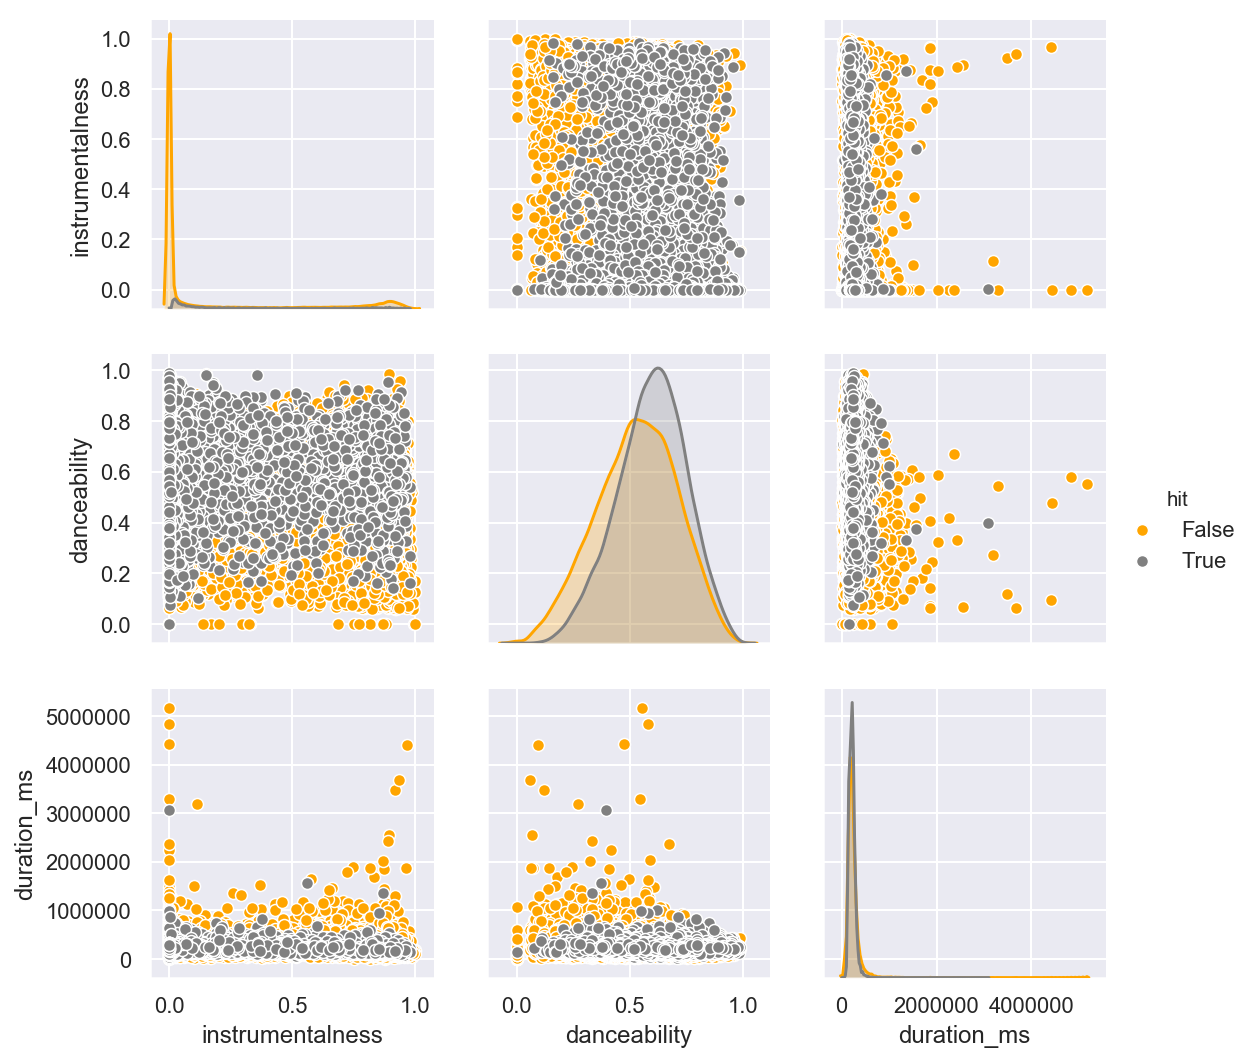

In [488]:
combined.loc[:,'longest_streak'] = 0
combined.loc[longest_streak.index,'longest_streak'] = 1
combined_nodupl = combined.loc[combined.index.drop_duplicates(),:]

combined_nodupl = combined_nodupl.dropna(subset=['id'])

combined_nodupl.loc[combined_nodupl['longest_streak'] == 1,main_cols_analysis].info()

sns.pairplot(combined_nodupl.loc[:,['instrumentalness','danceability','duration_ms','hit']], hue='hit', vars=['instrumentalness','danceability','duration_ms'])

danceability


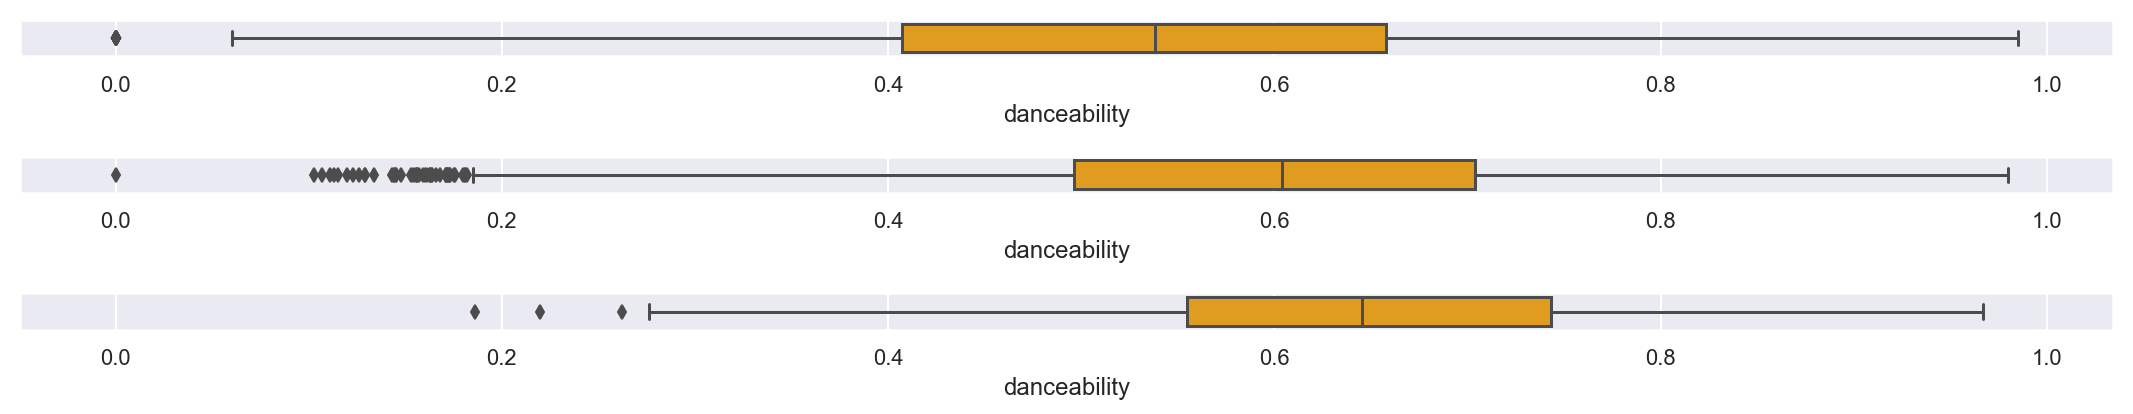

energy


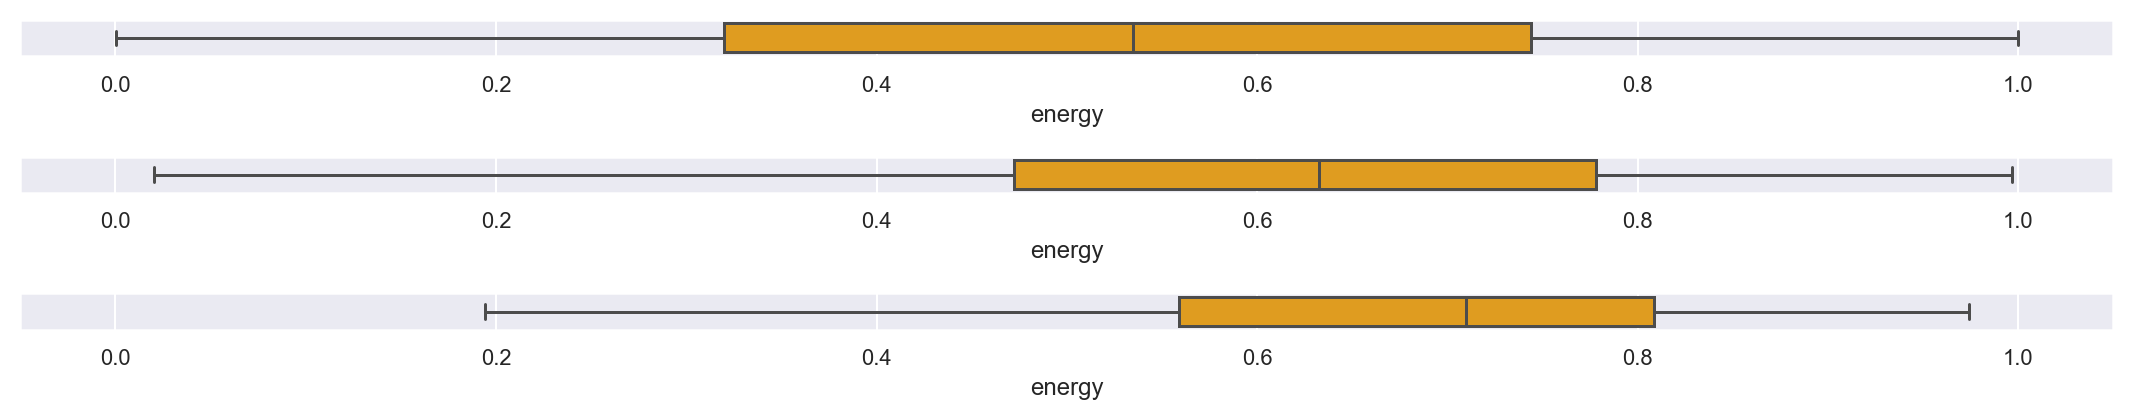

key


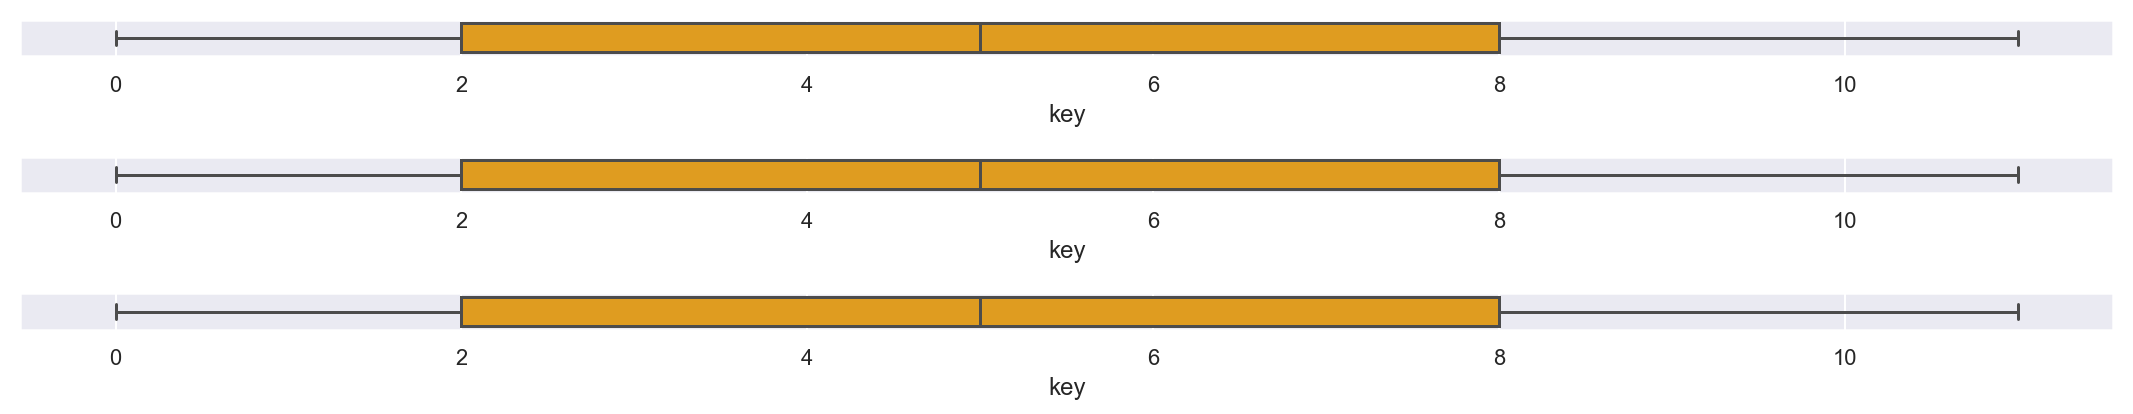

loudness


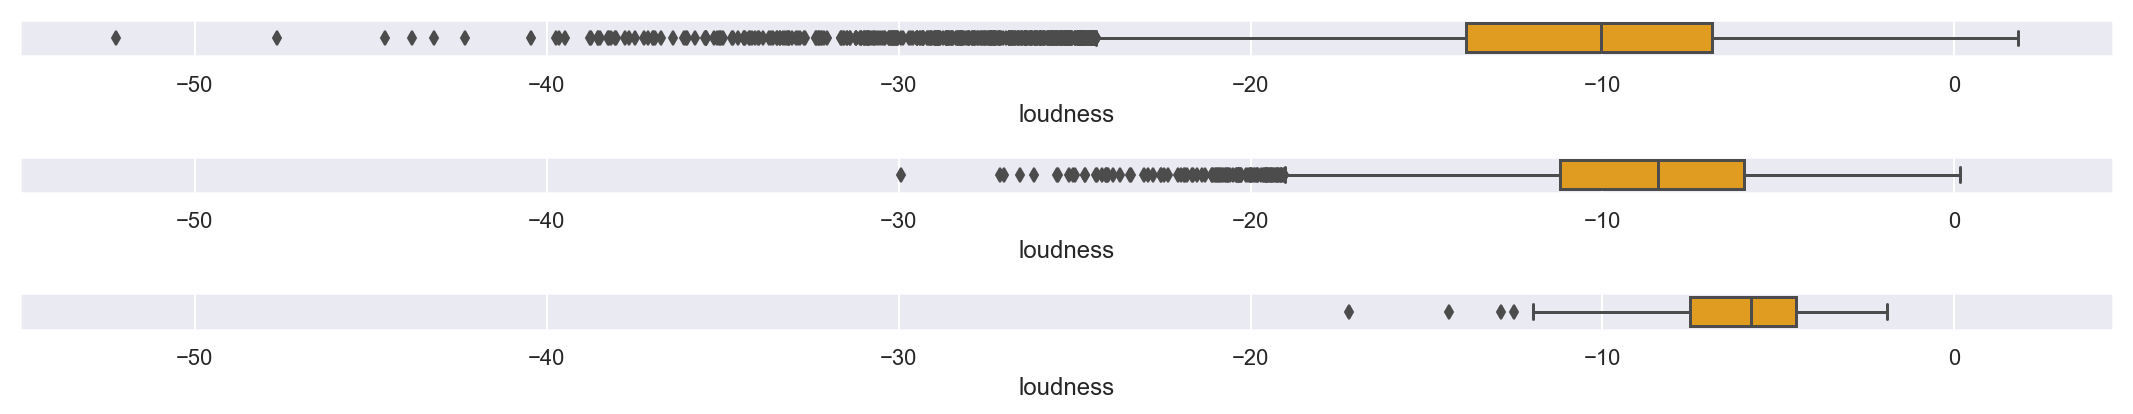

mode


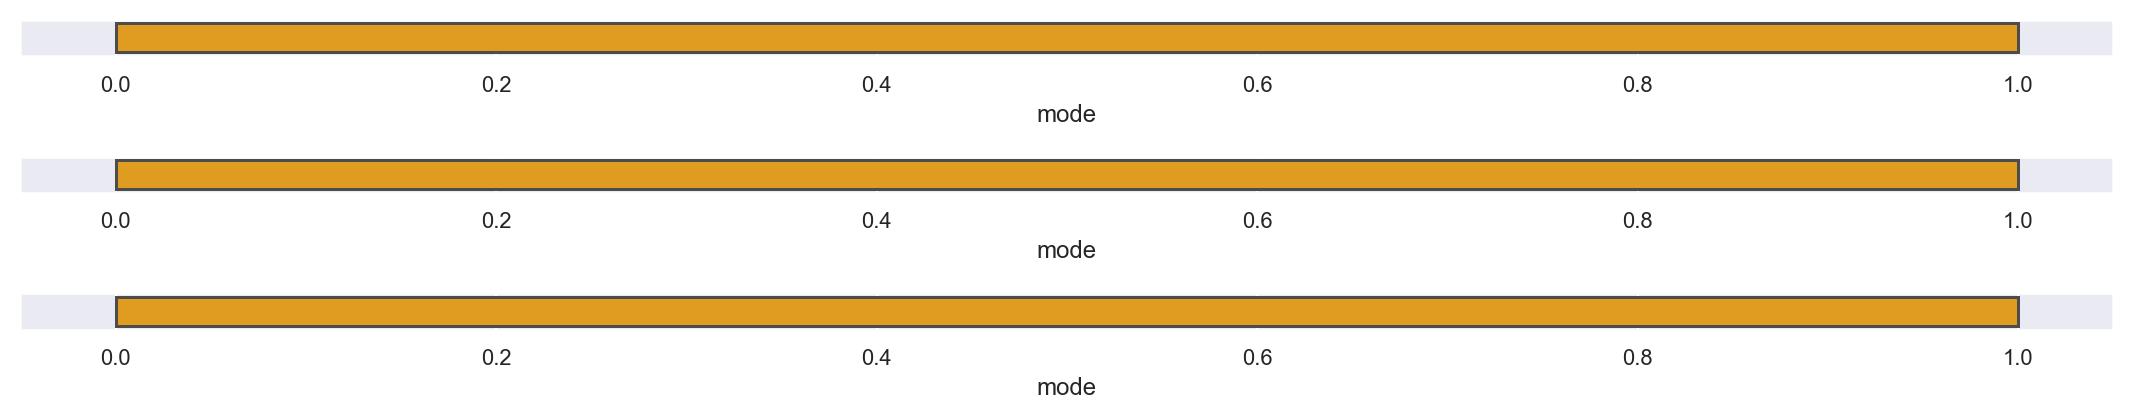

speechiness


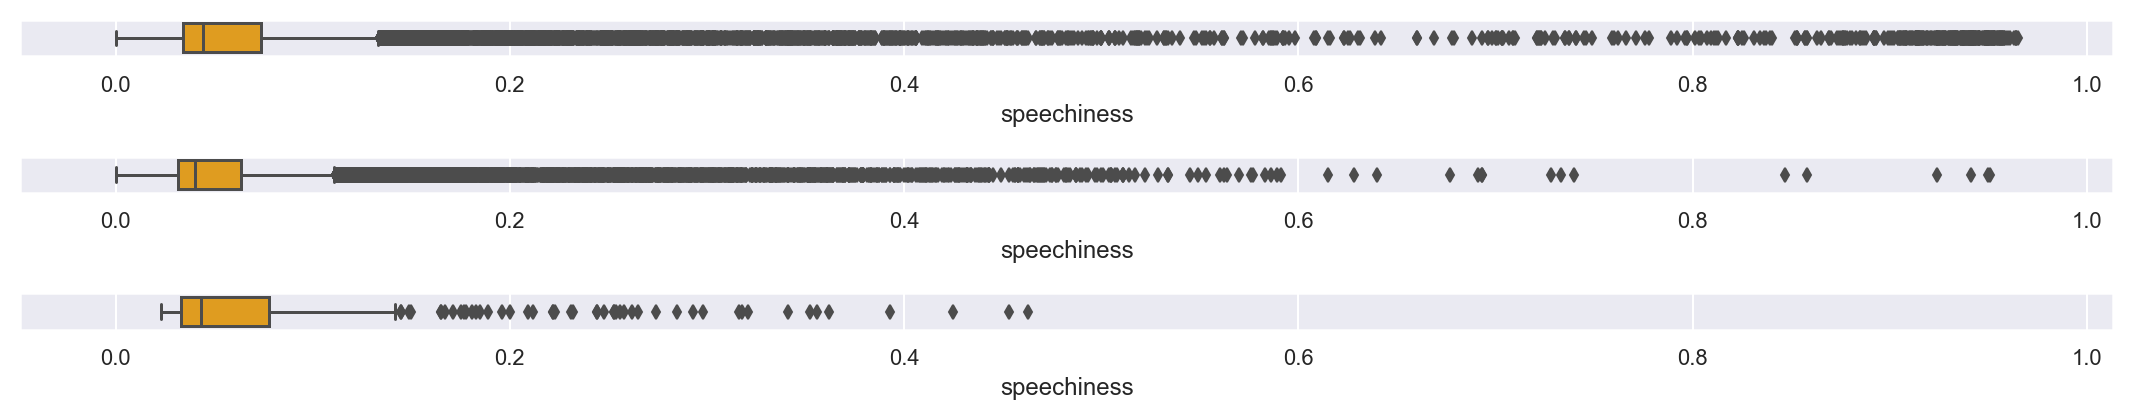

acousticness


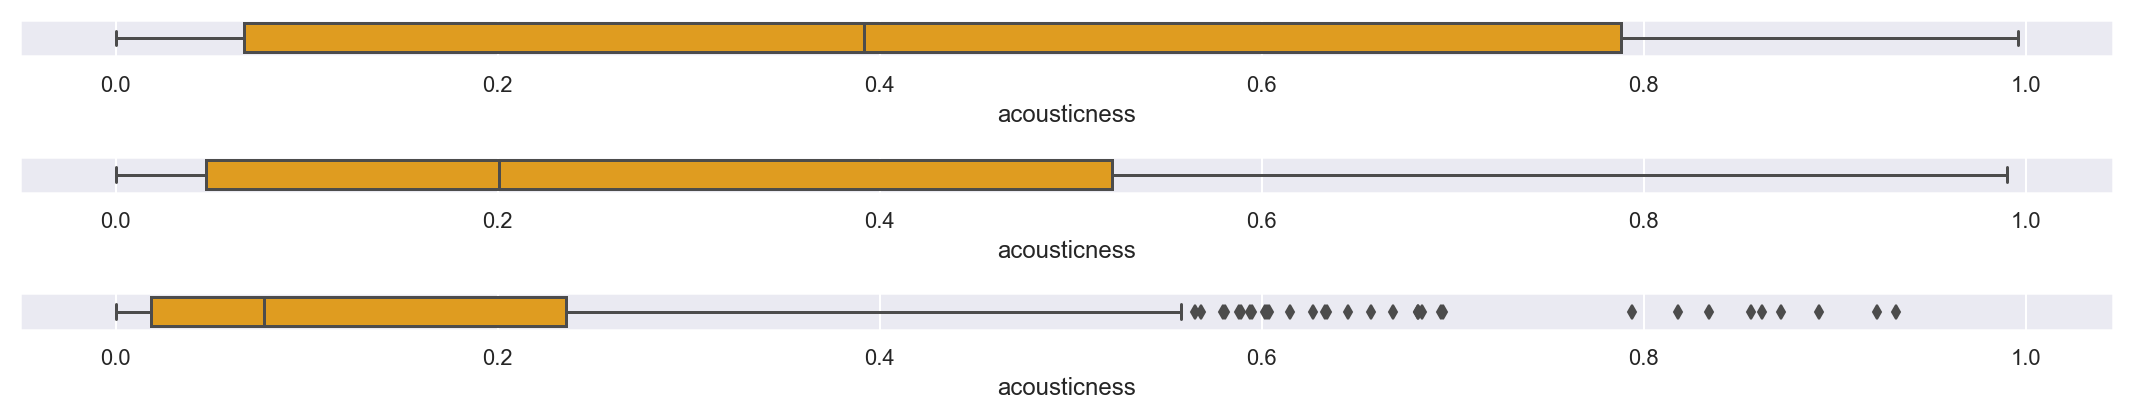

instrumentalness


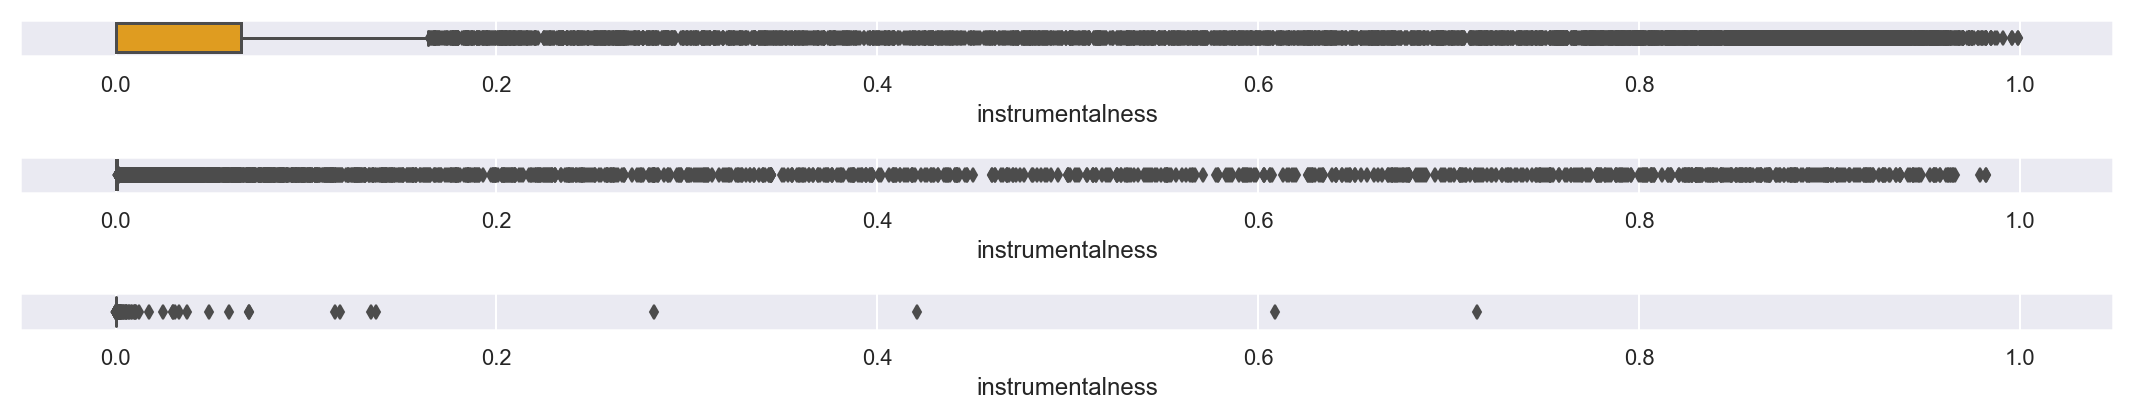

liveness


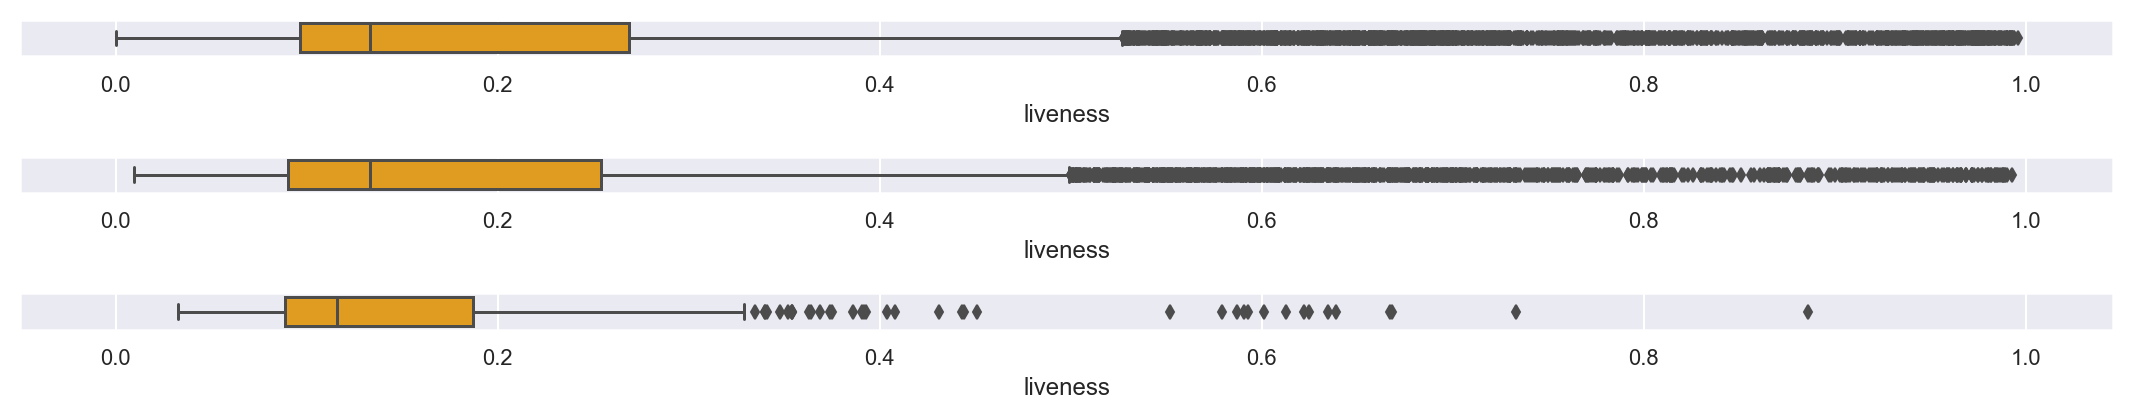

valence


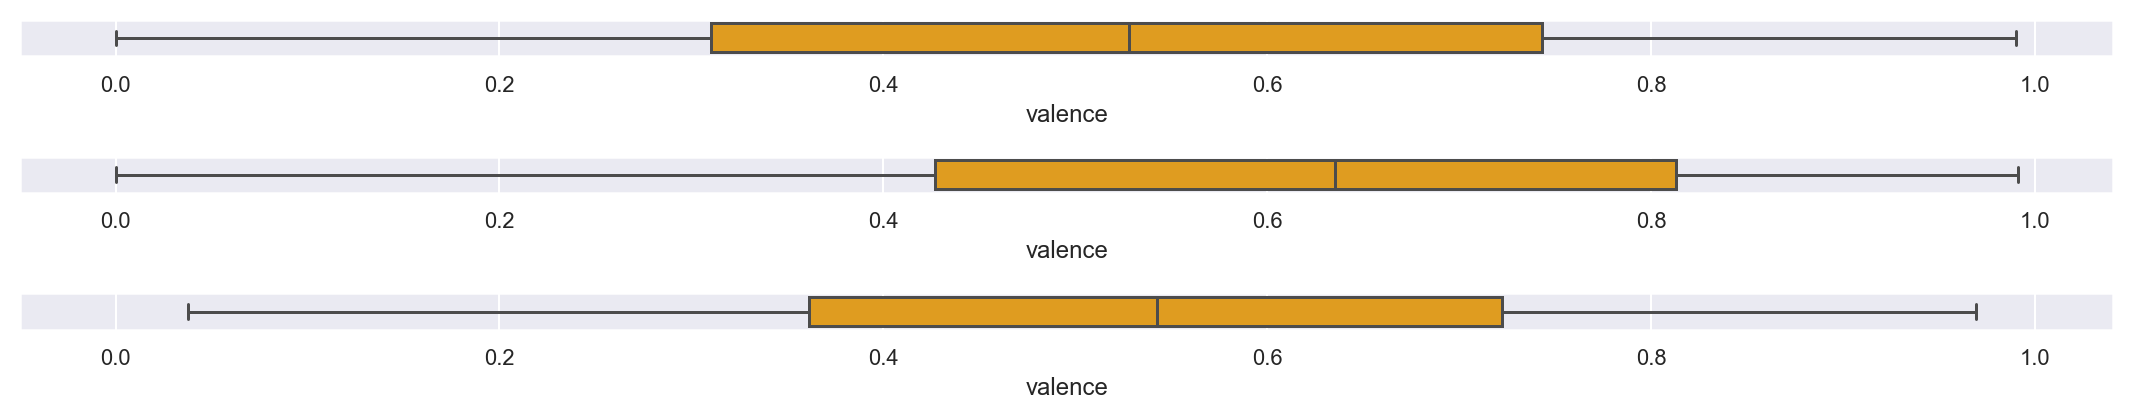

tempo


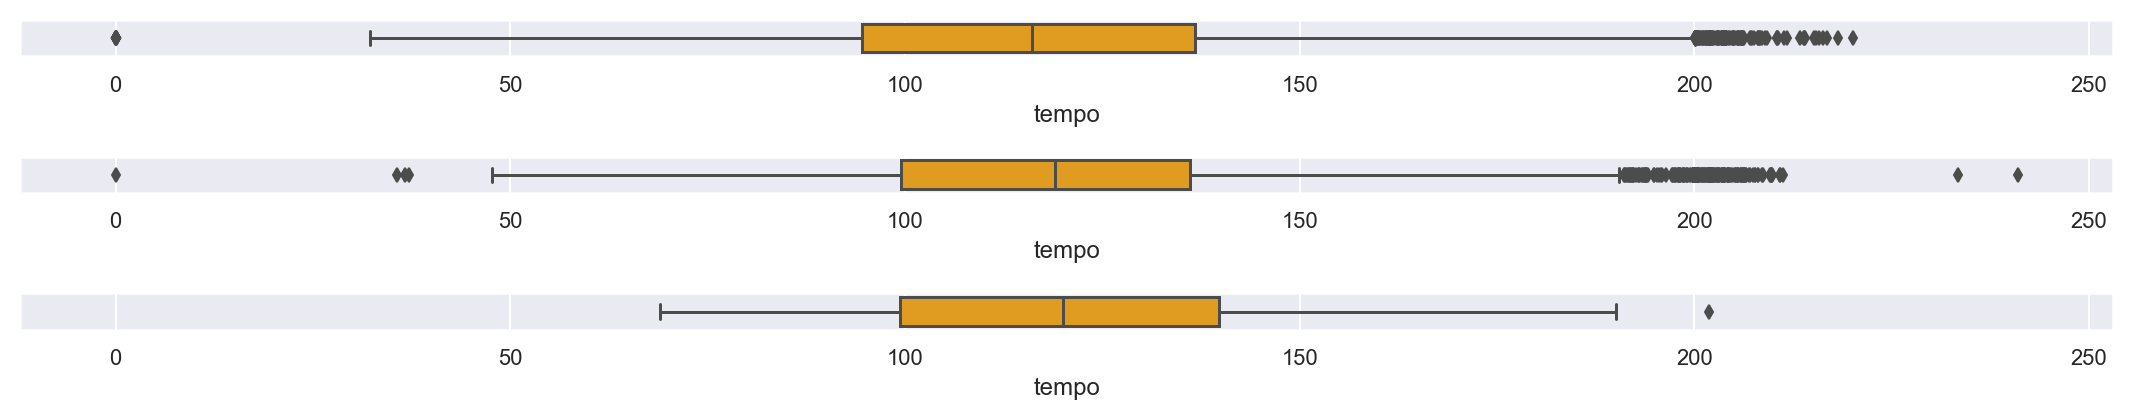

duration_ms


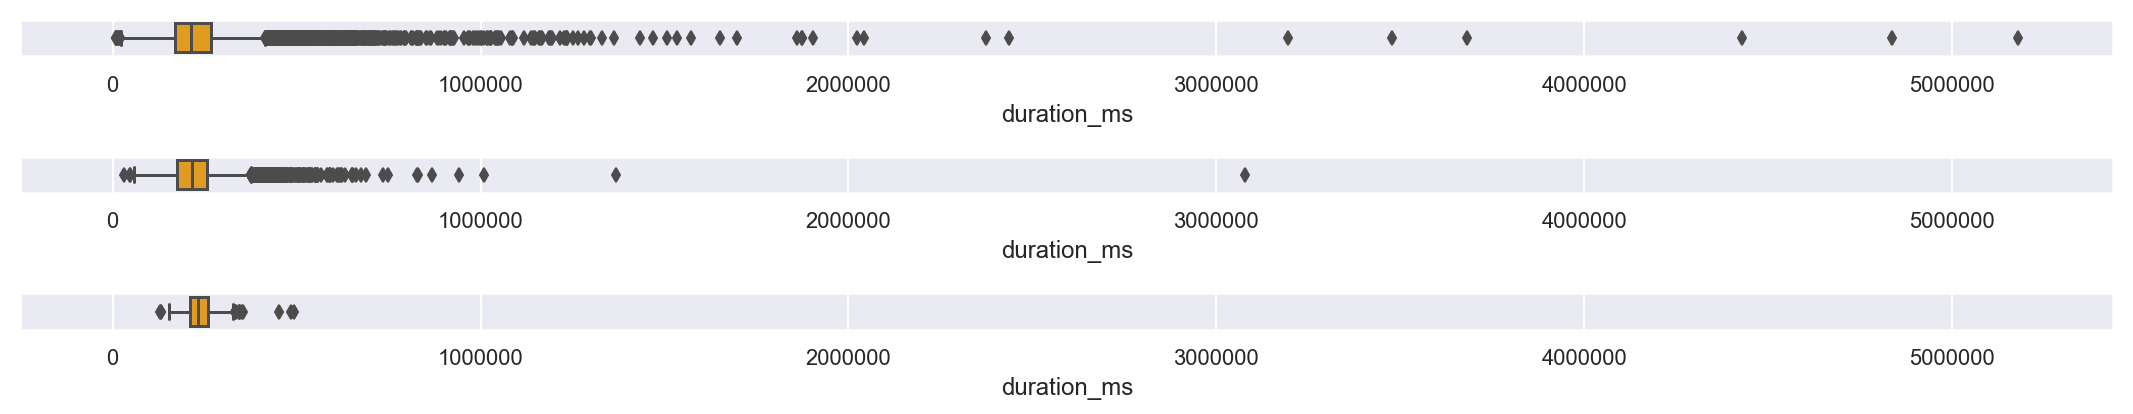

time_signature


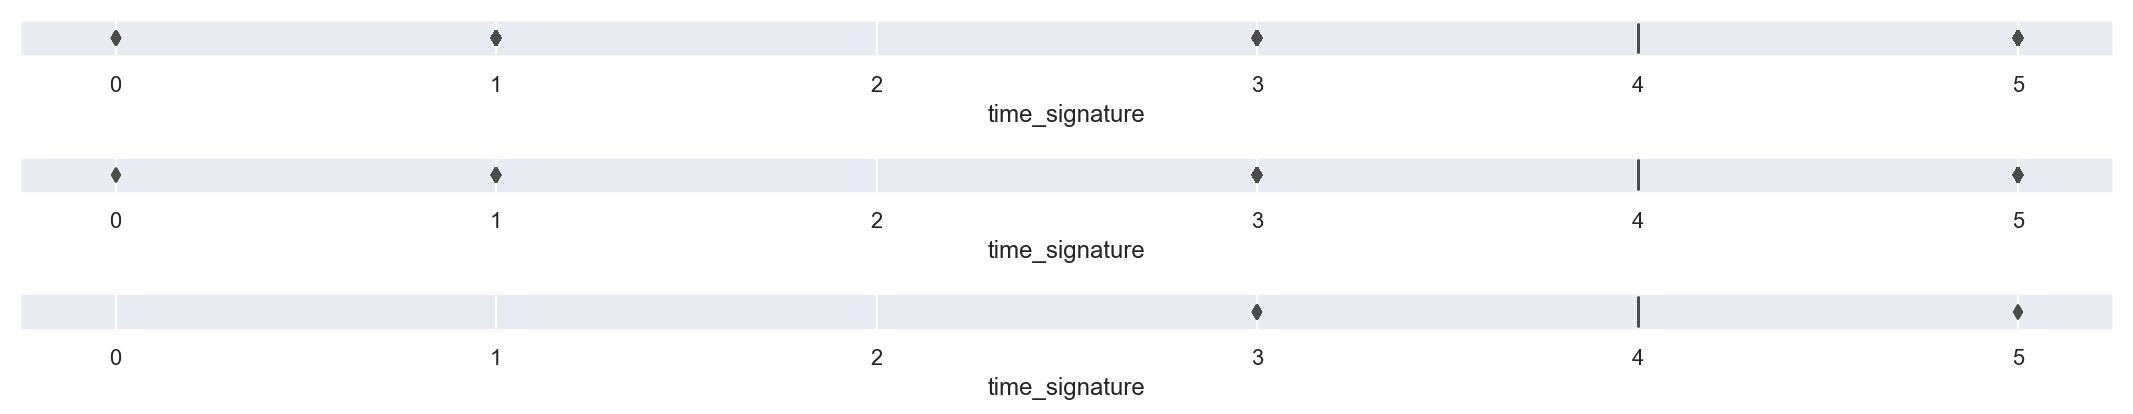

In [489]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']

for feature in features:
    print(feature)
    fig, ax = plt.subplots(3,figsize=(15,3))
    plt.title(feature)
    max_x = longest_streak_analysis.loc[:,feature].max()
    min_x = longest_streak_analysis.loc[:,feature].min()
    
    plt.xlim(min_x,max_x)
    
    plt.subplot(3,1,1,sharex=ax[0])
    sns.boxplot(nhits.loc[:,feature])
    plt.tight_layout()

    plt.subplot(3,1,2,sharex=ax[0])
    sns.boxplot(hits.loc[:,feature])
    plt.tight_layout()

    plt.subplot(3,1,3,sharex=ax[0])
    sns.boxplot(longest_streak_analysis.loc[:,feature])
    plt.tight_layout()
    plt.show()

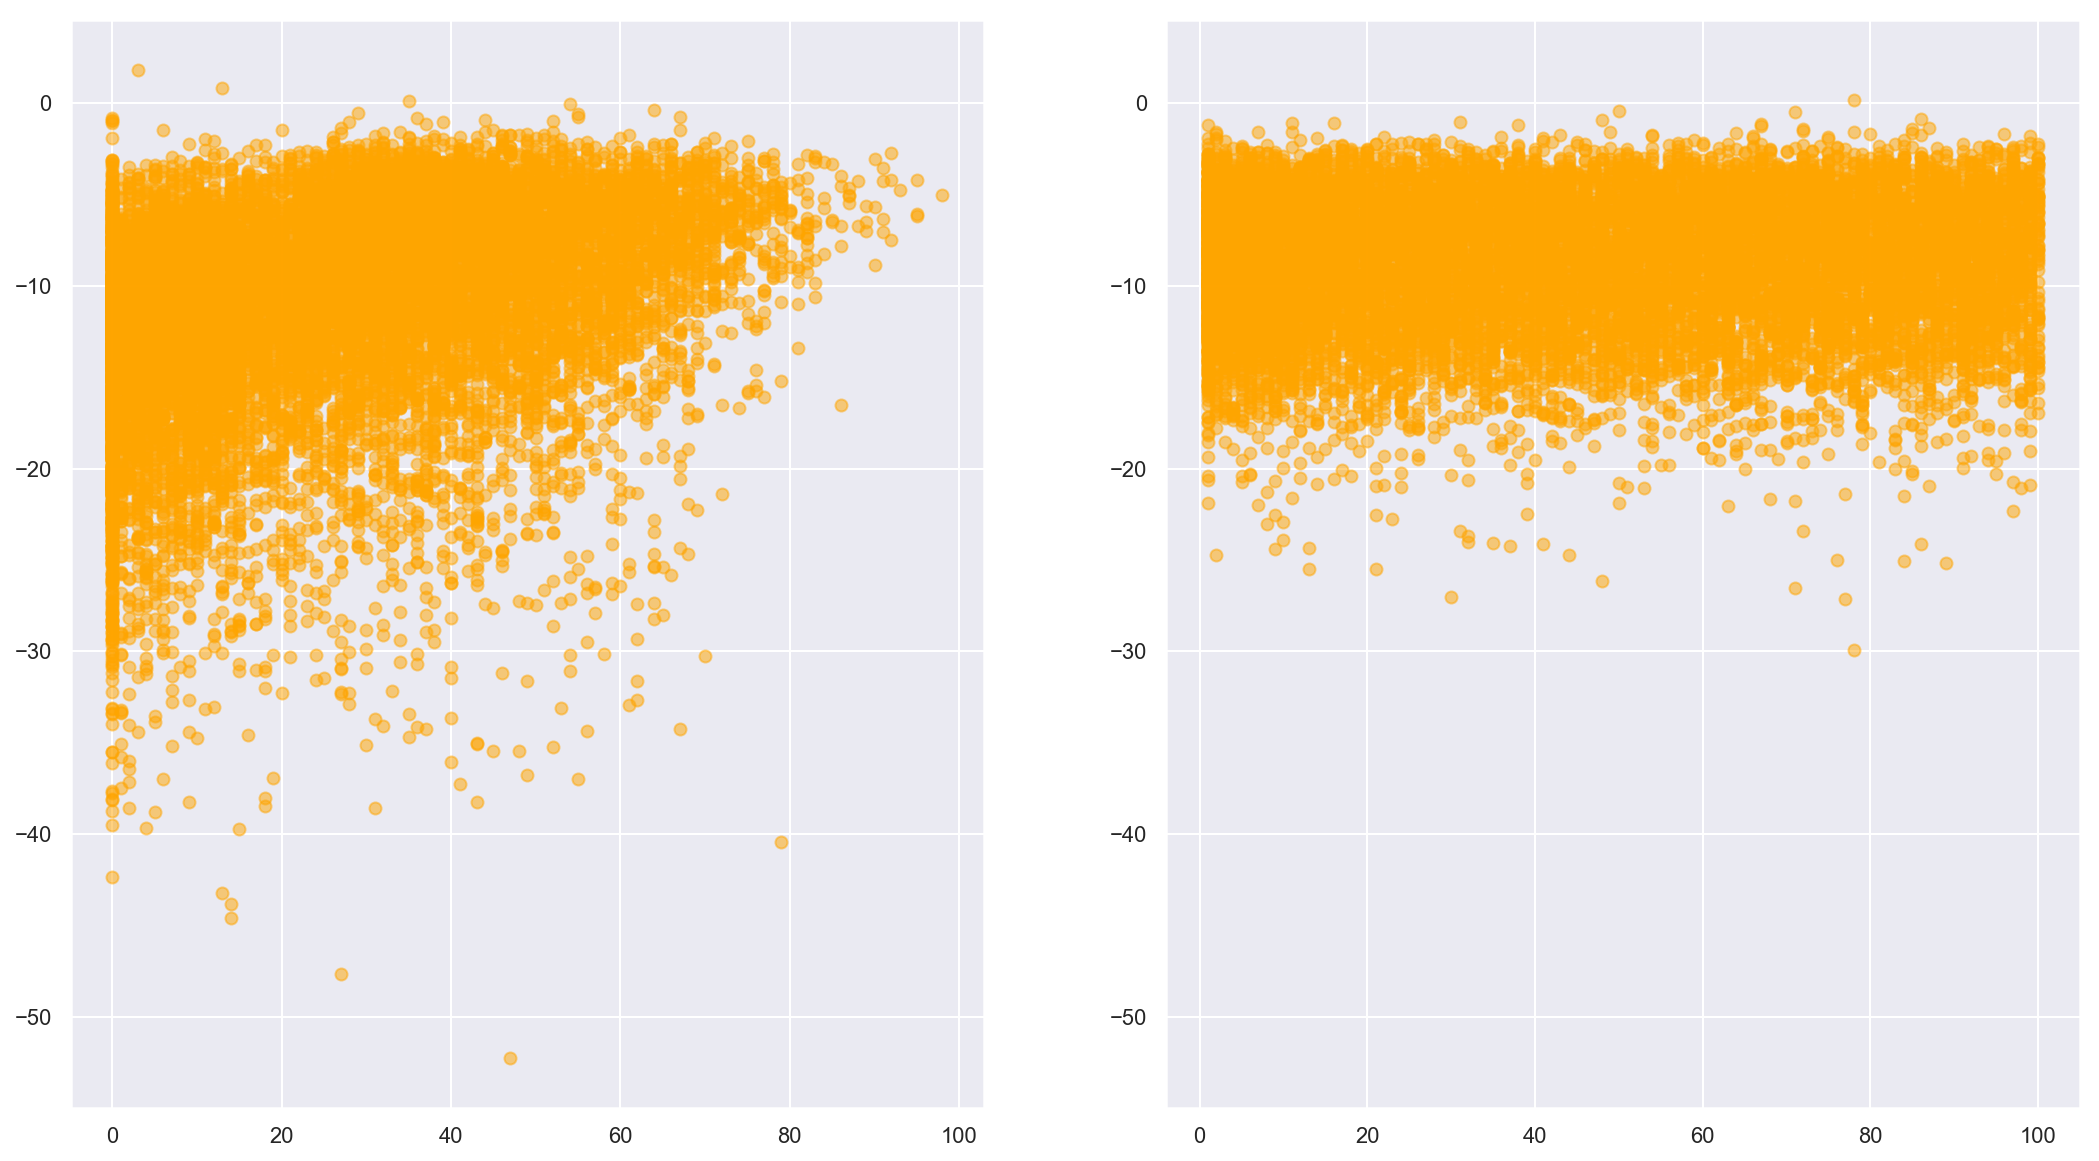

In [490]:
fig, ax = plt.subplots(1,2,figsize=(18,10),sharey=True)

plt.subplot(1,2,1,sharey=ax[0])
plt.scatter(nhits.loc[:,'popularity'],nhits.loc[:,'loudness'],alpha=0.5)

plt.subplot(1,2,2,sharey=ax[0])
plt.scatter(hits.loc[:,'peak'],hits.loc[:,'loudness'],alpha=0.5)

In [216]:
birthday_hit = pd.merge(hot100,longest_nr_1,on=['artist','title'],how='inner')
birthday_hit = birthday_hit.loc[birthday_hit['rank'] == 1,:]
sebastian = birthday_hit.loc[(birthday_hit['year'] == 1989) & (birthday_hit['month'] == 11) & (birthday_hit['day'] >= 1) & (birthday_hit['day'] < (1 + 7)),:]
brett = birthday_hit.loc[(birthday_hit['year'] == 1987) & (birthday_hit['month'] == 11) & (birthday_hit['day'] >= 26) & (birthday_hit['day'] < (26 + 7)),:]
becci = birthday_hit.loc[(birthday_hit['year'] == 1979) & (birthday_hit['month'] == 12) & (birthday_hit['day'] >= 26) & (birthday_hit['day'] < (26 + 7)),:]
maxi = birthday_hit.loc[(birthday_hit['year'] == 2009) & (birthday_hit['month'] == 10) & (birthday_hit['day'] >= 12) & (birthday_hit['day'] < (12 + 7)),:]
felix = birthday_hit.loc[(birthday_hit['year'] == 2013) & (birthday_hit['month'] == 3) & (birthday_hit['day'] >= 13) & (birthday_hit['day'] < (13 + 7)),:]
emil = birthday_hit.loc[(birthday_hit['year'] == 2014) & (birthday_hit['month'] == 12) & (birthday_hit['day'] >= 18) & (birthday_hit['day'] < (18 + 7)),:]
lilly = birthday_hit.loc[(birthday_hit['year'] == 2019) & (birthday_hit['month'] == 4) & (birthday_hit['day'] >= 9) & (birthday_hit['day'] < (9 + 7)),:]
emil

,rank,date,year,month,day,title,artist,week,reentry,streak,ranked,entry_date,entry_week,entry,entry_year,entry_month,entry_day,exit_date,exit_week,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_week,peak_year,peak_month,peak_day,leap_week,leap,max_leap,max_leap_date,max_leap_week,max_leap_year,max_leap_month,max_leap_day,low,weeks
8775,1,2014-12-20,2014,12,20,Blank Space,Taylor Swift,6,0,35,36,2014-11-15,1,18,2014,11,15,2015-07-18,36,50,2015,7,18,1,2014-11-15,1,2014,11,15,6,0.0,12.0,2014-11-29,3.0,2014.0,11.0,29.0,50,7


In [230]:
hot100.loc[hot100['rank'] == 10,:].head()

,rank,date,year,month,day,title,artist,week,reentry,streak,ranked,entry_date,entry_week,entry,entry_year,entry_month,entry_day,exit_date,exit_week,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_week,peak_year,peak_month,peak_day,leap_week,leap,max_leap,max_leap_date,max_leap_week,max_leap_year,max_leap_month,max_leap_day,low
9,10,1967-07-08,1967,7,8,The Tracks Of My Tears,Johnny Rivers,6,0,8,9,1967-06-03,1,70,1967,6,3,1967-07-29,9,49,1967,7,29,10,1967-06-03,1,1967,6,3,6,3.0,25.0,1967-06-10,2.0,1967.0,6.0,10.0,70
109,10,1992-11-14,1992,11,14,Jump Around,House Of Pain,21,0,29,30,1992-06-27,1,98,1992,6,27,1993-01-16,30,47,1993,1,16,3,1992-06-27,1,1992,6,27,21,-4.0,22.0,1992-07-11,3.0,1992.0,7.0,11.0,98
209,10,1980-06-07,1980,6,7,Little Jeannie,Elton John,6,0,20,21,1980-05-03,1,65,1980,5,3,1980-09-20,21,97,1980,9,20,3,1980-05-03,1,1980,5,3,6,3.0,27.0,1980-05-10,2.0,1980.0,5.0,10.0,97
309,10,1977-06-18,1977,6,18,Angel In Your Arms,Hot,18,0,26,27,1977-02-19,1,90,1977,2,19,1977-08-20,27,61,1977,8,20,6,1977-02-19,1,1977,2,19,18,1.0,11.0,1977-03-19,5.0,1977.0,3.0,19.0,90
409,10,1980-06-21,1980,6,21,She's Out Of My Life,Michael Jackson,10,0,15,16,1980-04-19,1,57,1980,4,19,1980-08-02,16,96,1980,8,2,10,1980-04-19,1,1980,4,19,10,1.0,11.0,1980-05-10,4.0,1980.0,5.0,10.0,96


In [52]:
Xy_test = test.loc[:,features+predictor].dropna()
test_X = Xy_test[features]
test_y = Xy_test[predictor]
test_pred = rf.predict(test_X[features])
accuracy_score(test_y,test_pred)

0.6662091503267974